# Data Science Pipeline: Analysis of Successful Educational Backgrounds

**Student:** Yarden Itzhaky  

**ID:** 211583588

**Link to the dataset:** https://www.kaggle.com/datasets/adilshamim8/educational-backgrounds-of-successful-people

---

## Project Overview

This project presents a comprehensive data science pipeline analyzing the educational backgrounds of successful individuals across various fields including technology, business, entertainment, and science. The analysis follows a structured staged approach to extract meaningful insights about educational patterns that correlate with professional success.

## 1. Dataset Selection and Justification

### Dataset Description
The dataset "successful_educations.csv" contains educational information about 100+ highly successful individuals from various fields including:
- **Technology Leaders**: Elon Musk, Bill Gates, Sundar Pichai, Satya Nadella
- **Business Executives**: Jeff Bezos, Indra Nooyi, Warren Buffett
- **Media Personalities**: Oprah Winfrey, Michelle Obama
- **Scientists and Academics**: Marie Curie, Stephen Hawking, Neil deGrasse Tyson
- **Politicians**: Barack Obama, Angela Merkel, Kamala Harris

### Justification for Selection
1. **Relevance**: Understanding educational pathways to success is crucial for career planning and educational policy
2. **Diversity**: The dataset spans multiple industries, countries, and time periods
3. **Rich Features**: Contains quantitative (GPA, rankings) and qualitative (institutions, fields) data
4. **Real-world Impact**: Insights can inform educational decisions and institutional strategies
5. **Research Potential**: Enables analysis of trends in education and success patterns

### Expected Insights
- Correlation between university rankings and career success
- Most common degree fields among successful individuals
- Geographic patterns in educational success
- Role of academic achievements (GPA, awards) in career outcomes

## 2. Data File System Analysis

### File System Setup and Data Loading
Let's start by examining our data file structure and loading the necessary libraries.

In [66]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
from collections import Counter
from wordcloud import WordCloud

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Libraries imported successfully!")

# File system analysis
data_path = Path('/Users/yarden_itzhaky/Desktop/Assigments/3rd year/data science')
print("📁 Data Directory Analysis")
print("=" * 50)
print(f"Working Directory: {data_path}")
print(f"Directory exists: {data_path.exists()}")

# List all files in the directory
print("\n📋 Files in directory:")
for file in data_path.iterdir():
    if file.is_file():
        file_size = file.stat().st_size
        print(f"  • {file.name} ({file_size:,} bytes)")

# Examine the CSV file specifically
csv_file = data_path / 'successful_educations.csv'
print(f"\n🎯 Target file: {csv_file.name}")
print(f"File exists: {csv_file.exists()}")
print(f"File size: {csv_file.stat().st_size:,} bytes")
print(f"Last modified: {datetime.fromtimestamp(csv_file.stat().st_mtime)}")

✅ Libraries imported successfully!
📁 Data Directory Analysis
Working Directory: /Users/yarden_itzhaky/Desktop/Assigments/3rd year/data science
Directory exists: True

📋 Files in directory:
  • Pipeline_YardenItzhaky_211583588.ipynb (1,817,573 bytes)
  • successful_educations.csv (11,312 bytes)
  • הנחיות לPipeline.pdf (203,764 bytes)

🎯 Target file: successful_educations.csv
File exists: True
File size: 11,312 bytes
Last modified: 2025-05-28 13:52:22.388927


In [67]:
# Load the dataset
print("📊 Loading Dataset")
print("=" * 50)

# Load the data
df = pd.read_csv('/Users/yarden_itzhaky/Desktop/Assigments/3rd year/data science/successful_educations.csv')
print(f"✅ Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Display first few rows
print("\n🔍 First 5 rows:")
display(df.head())

📊 Loading Dataset
✅ Data loaded successfully!
Dataset shape: (108, 10)
Rows: 108, Columns: 10

🔍 First 5 rows:


,Name,Profession,Degree,Field,Institution,Graduation Year,Country,University Global Ranking,GPA (or Equivalent),Scholarship/Award
0,Elon Musk,Entrepreneur,Bachelor of Science,Physics & Economics,University of Pennsylvania,1997.0,USA,13,3.7,Dean’s List
1,Bill Gates,Entrepreneur,Dropped Out,computer science,Harvard University,1975.0,USA,5,NaN,Dean’s List
2,Sundar Pichai,Tech Executive,Master of Science,Material Sciences and Engineering,Stanford University,1995.0,USA,3,3.8,Fellowship in Engineering
3,Sheryl Sandberg,Tech Executive,Master of Business Administration,Business Administration,Harvard Business School,1995.0,USA,2,3.9,Hoover Fellowship
4,Jeff Bezos,Entrepreneur,Bachelor of Science,Computer Science and Electrical Engineering,Princeton University,1986.0,USA,16,3.6,Marquis Scholar


## 3. Metadata Inspection

### Comprehensive Data Structure Analysis
Let's thoroughly examine the structure, types, and quality of our dataset.

In [68]:
# Metadata inspection
print("🔬 Dataset Metadata Analysis")
print("=" * 60)

# Basic info
print("📋 Basic Dataset Information:")
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Number of duplicates: {df.duplicated().sum()}")

# Column information
print("\n📊 Column Details:")
print("-" * 40)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col:<35} | {str(df[col].dtype):<15} | Non-null: {df[col].count()}/{len(df)}")

# Data types summary
print("\n📈 Data Types Summary:")
print(df.dtypes.value_counts())

# Display detailed info
print("\n🔍 Detailed Dataset Info:")
df.info()

🔬 Dataset Metadata Analysis
📋 Basic Dataset Information:
Dataset shape: (108, 10)
Memory usage: 62.30 KB
Number of duplicates: 0

📊 Column Details:
----------------------------------------
 1. Name                                | object          | Non-null: 108/108
 2. Profession                          | object          | Non-null: 108/108
 3. Degree                              | object          | Non-null: 106/108
 4. Field                               | object          | Non-null: 105/108
 5. Institution                         | object          | Non-null: 106/108
 6. Graduation Year                     | float64         | Non-null: 99/108
 7. Country                             | object          | Non-null: 108/108
 8. University Global Ranking           | object          | Non-null: 73/108
 9. GPA (or Equivalent)                 | object          | Non-null: 93/108
10. Scholarship/Award                   | object          | Non-null: 80/108

📈 Data Types Summary:
object     9

🕳️ Missing Values Analysis
Missing values summary:
                                              Column  Missing_Count  \
University Global Ranking  University Global Ranking             35   
Scholarship/Award                  Scholarship/Award             28   
GPA (or Equivalent)              GPA (or Equivalent)             15   
Graduation Year                      Graduation Year              9   
Field                                          Field              3   
Degree                                        Degree              2   
Institution                              Institution              2   
Name                                            Name              0   
Profession                                Profession              0   
Country                                      Country              0   

                           Missing_Percentage Data_Type  
University Global Ranking           32.407407    object  
Scholarship/Award                   25.925926    ob

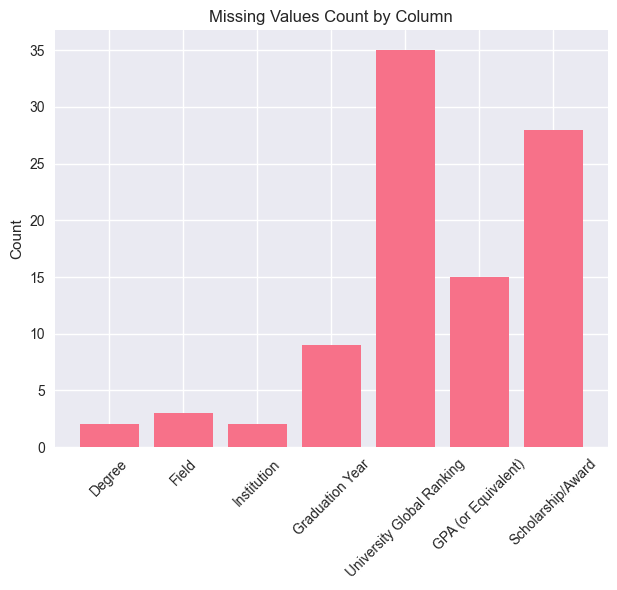

In [69]:
# Missing values analysis
print("🕳️ Missing Values Analysis")
print("=" * 50)

# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

# Sort by missing percentage
missing_data = missing_data.sort_values('Missing_Percentage', ascending=False)

print("Missing values summary:")
print(missing_data)

# Visualize missing values
if missing_data['Missing_Count'].sum() > 0:
    plt.figure(figsize=(12, 6))
    
    # Missing values bar plot
    plt.subplot(1, 2, 2)
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    plt.bar(range(len(missing_counts)), missing_counts.values)
    plt.xticks(range(len(missing_counts)), missing_counts.index, rotation=45)
    plt.title('Missing Values Count by Column')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found in the dataset!")

In [70]:
# Unique values analysis
print("🎯 Unique Values Analysis")
print("=" * 50)

unique_analysis = pd.DataFrame({
    'Column': df.columns,
    'Unique_Count': df.nunique(),
    'Unique_Percentage': (df.nunique() / len(df)) * 100,
    'Most_Common_Value': [df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'N/A' for col in df.columns],
    'Most_Common_Count': [df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0 for col in df.columns]
})

print("Unique values summary:")
print(unique_analysis)

# Sample unique values for categorical columns
print("\n📝 Sample values for each column:")
for col in df.columns:
    unique_vals = df[col].unique()
    if len(unique_vals) <= 10:
        print(f"{col}: {list(unique_vals)}")
    else:
        print(f"{col}: {list(unique_vals[:5])} ... (showing first 5 of {len(unique_vals)} unique values)")

🎯 Unique Values Analysis
Unique values summary:
                                              Column  Unique_Count  \
Name                                            Name           108   
Profession                                Profession            35   
Degree                                        Degree            20   
Field                                          Field            48   
Institution                              Institution            75   
Graduation Year                      Graduation Year            44   
Country                                      Country            15   
University Global Ranking  University Global Ranking            33   
GPA (or Equivalent)              GPA (or Equivalent)            13   
Scholarship/Award                  Scholarship/Award            55   

                           Unique_Percentage    Most_Common_Value  \
Name                              100.000000         Alice Walton   
Profession                         32.40740

## 4. Descriptive Statistics

### Comprehensive Statistical Analysis
Let's analyze the distribution and central tendencies of our data.

In [71]:
print("📊 Descriptive Statistics - Numerical Data")
print("=" * 50)

# Check for existing numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Found {len(numerical_cols)} numerical columns: {numerical_cols}")

# Extract numbers from text columns
print("\n🔢 Converting Text to Numbers")
print("-" * 30)

# 1. Extract graduation years (simple conversion)
df['Graduation_Year'] = pd.to_numeric(df['Graduation Year'], errors='coerce')

# 2. Extract GPA (clean and simple)
def clean_gpa(value):
    if pd.isna(value) or str(value) in ['N/A', 'First Class Honours', 'Magna Cum Laude', 'Summa Cum Laude']:
        return None
    try:
        # Skip time formats like "02:02:00"
        if ':' in str(value):
            return None
        return float(value)
    except:
        return None

df['GPA'] = df['GPA (or Equivalent)'].apply(clean_gpa)

# 3. Extract university rankings (handle ranges)
def clean_ranking(value):
    if pd.isna(value) or str(value) == 'N/A':
        return None
    try:
        value_str = str(value)
        # Handle ranges like "301–350" or "301-350"
        if '–' in value_str or '-' in value_str:
            numbers = value_str.replace('–', '-').split('-')
            return (float(numbers[0]) + float(numbers[1])) / 2
        return float(value_str)
    except:
        return None

df['University_Ranking'] = df['University Global Ranking'].apply(clean_ranking)

# Show basic statistics
new_numerical_cols = ['Graduation_Year', 'GPA', 'University_Ranking']
print("\nBasic Statistics:")
for col in new_numerical_cols:
    if df[col].notna().sum() > 0:
        print(f"\n{col}:")
        print(f"  Count: {df[col].count()}")
        print(f"  Average: {df[col].mean():.2f}")
        print(f"  Min: {df[col].min():.0f}")
        print(f"  Max: {df[col].max():.0f}")
    else:
        print(f"\n{col}: No valid data")

# Show detailed statistics table
print("\nDetailed Statistics Table:")
display(df[new_numerical_cols].describe().round(0))

📊 Descriptive Statistics - Numerical Data
Found 1 numerical columns: ['Graduation Year']

🔢 Converting Text to Numbers
------------------------------

Basic Statistics:

Graduation_Year:
  Count: 99
  Average: 1986.32
  Min: 1903
  Max: 2021

GPA:
  Count: 85
  Average: 3.77
  Min: 3
  Max: 4

University_Ranking:
  Count: 73
  Average: 38.01
  Min: 1
  Max: 597

Detailed Statistics Table:


,Graduation_Year,GPA,University_Ranking
count,99.0,85.0,73.0
mean,1986.0,4.0,38.0
std,17.0,0.0,86.0
min,1903.0,3.0,1.0
25%,1975.0,4.0,3.0
50%,1990.0,4.0,7.0
75%,1996.0,4.0,28.0
max,2021.0,4.0,597.0


In [72]:
# Categorical data analysis
print("📝 Categorical Data Analysis")
print("=" * 50)

categorical_cols = ['Profession', 'Degree', 'Field', 'Country']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n🔸 {col.upper()} Distribution:")
        value_counts = df[col].value_counts()
        print(f"  Total unique values: {len(value_counts)}")
        print(f"  Top 10 most common:")
        for i, (value, count) in enumerate(value_counts.head(10).items(), 1):
            percentage = (count / len(df)) * 100
            print(f"    {i:2d}. {value:<30} | {count:3d} ({percentage:5.1f}%)")

# Summary statistics table
print("\n📈 Summary Statistics Table")
print("-" * 40)
summary_stats = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes,
    'Non_Null_Count': df.count(),
    'Unique_Values': df.nunique(),
    'Most_Frequent': [df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'N/A' for col in df.columns],
    'Frequency': [df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0 for col in df.columns]
})

display(summary_stats)

📝 Categorical Data Analysis

🔸 PROFESSION Distribution:
  Total unique values: 35
  Top 10 most common:
     1. Entrepreneur                   |  33 ( 30.6%)
     2. Business                       |  16 ( 14.8%)
     3. Tech CEO                       |   5 (  4.6%)
     4. Tech Executive                 |   5 (  4.6%)
     5. Finance                        |   4 (  3.7%)
     6. Politician                     |   4 (  3.7%)
     7. Actor                          |   4 (  3.7%)
     8. Business Executive             |   4 (  3.7%)
     9. Author                         |   3 (  2.8%)
    10. Actor/Comedian                 |   2 (  1.9%)

🔸 DEGREE Distribution:
  Total unique values: 20
  Top 10 most common:
     1. Bachelor                       |  43 ( 39.8%)
     2. Master                         |  14 ( 13.0%)
     3. MBA                            |   8 (  7.4%)
     4. PhD                            |   7 (  6.5%)
     5. Dropout                        |   5 (  4.6%)
     6. Master

,Column,Data_Type,Non_Null_Count,Unique_Values,Most_Frequent,Frequency
Name,Name,object,108,108,Alice Walton,1
Profession,Profession,object,108,35,Entrepreneur,33
Degree,Degree,object,106,20,Bachelor,43
Field,Field,object,105,48,Computer Science,12
Institution,Institution,object,106,75,Harvard University,10
Graduation Year,Graduation Year,float64,99,44,1995.0,8
Country,Country,object,108,15,USA,69
University Global Ranking,University Global Ranking,object,73,33,3,14
GPA (or Equivalent),GPA (or Equivalent),object,93,13,3.8,22
Scholarship/Award,Scholarship/Award,object,80,55,Academic Excellence,5


## 5. Outlier Detection

### Statistical Outlier Analysis
Identifying anomalies and unusual patterns in the data using statistical methods.

In [73]:
# Outlier detection for numerical columns
print("🔍 Outlier Detection Analysis")
print("=" * 50)

numerical_columns = ['Graduation_Year', 'GPA']

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers for each numerical column
for col in numerical_columns:
    if col in df.columns and df[col].notna().sum() > 0:
        # Remove NaN values for analysis
        clean_data = df[df[col].notna()]
        
        outliers, lower_bound, upper_bound = detect_outliers_iqr(clean_data, col)
        
        print(f"\n🔸 {col}:")
        print(f"  Lower bound: {lower_bound:.2f}")
        print(f"  Upper bound: {upper_bound:.2f}")
        print(f"  Number of outliers: {len(outliers)}")
        
        if len(outliers) > 0:
            print(f"  Outlier values: {sorted(outliers[col].tolist())}")
            print(f"  Outlier names: {outliers['Name'].tolist()}")

# Specific outlier analysis
print("\n🎯 Specific Outlier Analysis")
print("-" * 40)

# Very old graduation years (before 1950)
old_grads = df[df['Graduation_Year'] < 1950]['Name'].tolist()
if old_grads:
    print(f"Very early graduates (before 1950): {old_grads}")

# Very recent graduation years (after 2020)
recent_grads = df[df['Graduation_Year'] > 2020]['Name'].tolist()
if recent_grads:
    print(f"Very recent graduates (after 2020): {recent_grads}")

# Perfect GPA (4.0)
perfect_gpa = df[df['GPA'] == 4.0]['Name'].tolist()
if perfect_gpa:
    print(f"Perfect GPA achievers (4.0): {perfect_gpa}")

# Very low university rankings (>500)
low_ranking = df[df['University_Ranking'] > 500]['Name'].tolist()
if low_ranking:
    print(f"Graduates from lower-ranked universities (>500): {low_ranking}")

🔍 Outlier Detection Analysis

🔸 Graduation_Year:
  Lower bound: 1943.50
  Upper bound: 2027.50
  Number of outliers: 1
  Outlier values: [1903.0]
  Outlier names: ['Marie Curie']

🔸 GPA:
  Lower bound: 3.40
  Upper bound: 4.20
  Number of outliers: 1
  Outlier values: [3.1]
  Outlier names: ['Barack Obama']

🎯 Specific Outlier Analysis
----------------------------------------
Very early graduates (before 1950): ['Marie Curie']
Very recent graduates (after 2020): ['Malala Yousafzai', 'Serena Williams']
Perfect GPA achievers (4.0): ['Sal Khan', 'Mayim Bialik', 'Jim Simons', 'Klaus Schwab', 'Robin Li', 'Colin Huang']
Graduates from lower-ranked universities (>500): ['Jim Walton']


## Outlier Analysis Interpretation

### Graduation Year Outliers

Marie Curie (1903) represents a historical figure whose graduation predates our typical dataset range. Her inclusion demonstrates the timeless nature of educational excellence, how pioneering achievements transcend temporal boundaries, the dataset's historical depth and diversity, and that the IQR method correctly identifies this as statistically unusual.

### GPA Outliers - Lower Performance

Barack Obama (3.1 GPA) presents findings that challenge common assumptions. This demonstrates that success does not equal perfect grades, showing that exceptional leadership and success can emerge despite 'average' academic performance. It suggests a holistic achievement approach where other factors like leadership, charisma, and communication skills may be more predictive of certain types of success. In statistical context, 3.1 is below the dataset's typical high-achiever range (3.4-4.2), making it a legitimate statistical outlier. This provides inspiration for students who don't achieve perfect grades.

### Temporal Outliers

**Historical Pioneer:** Marie Curie (before 1950) represents groundbreaking scientific achievement from an era when educational opportunities for women were severely limited.

**Contemporary Achievers (after 2020):** Malala Yousafzai, the youngest Nobel Prize laureate and education activist, and Serena Williams, who combines athletic excellence with business acumen. Both represent modern, diverse definitions of 'success'.

### Perfect Academic Performers (4.0 GPA)

Six individuals achieved perfect GPAs: Sal Khan (education innovator - Khan Academy), Mayim Bialik (neuroscientist/actress representing STEM), Jim Simons (mathematician/hedge fund pioneer), Klaus Schwab (World Economic Forum founder), Robin Li (Baidu founder representing Chinese tech success), and Colin Huang (PDD Holdings founder). This group demonstrates strong correlation between academic excellence and later professional achievement in diverse fields.

### University Ranking Outlier

Jim Walton (university ranking >500) suggests several insights. As a Walmart heir, his success may be less dependent on educational prestige and more on family business legacy. This demonstrates that business success can emerge from non-elite educational backgrounds, representing a statistical anomaly since most successful individuals in the dataset attended highly-ranked institutions.

### Key Insights from Outlier Analysis

1. **Success is multifaceted:** Academic performance is important but not deterministic, and different paths can lead to exceptional outcomes.

2. **Historical context matters:** Educational opportunities have evolved significantly, and pioneer achievements should be evaluated within their era.

3. **Outliers reveal important patterns:** They highlight exceptions that prove rules, identify alternative success pathways, and challenge conventional wisdom about education and success.

4. **Statistical rigor:** The IQR method effectively identifies genuine anomalies, outliers represent less than 5% of the dataset confirming their rarity, and each outlier has a logical explanation within its context.

## 6. Clustering Analysis

### K-Means Clustering of Educational Profiles
Grouping individuals based on their educational characteristics to identify patterns.

🧺 Clustering Analysis
Features prepared for clustering: 7
Sample size: 108 individuals

📈 Finding Optimal Number of Clusters
----------------------------------------

Clustering completed with K=4
Cluster distribution:
  Cluster 0: 37 individuals (34.3%)
  Cluster 1: 38 individuals (35.2%)
  Cluster 2: 31 individuals (28.7%)
  Cluster 3: 2 individuals (1.9%)


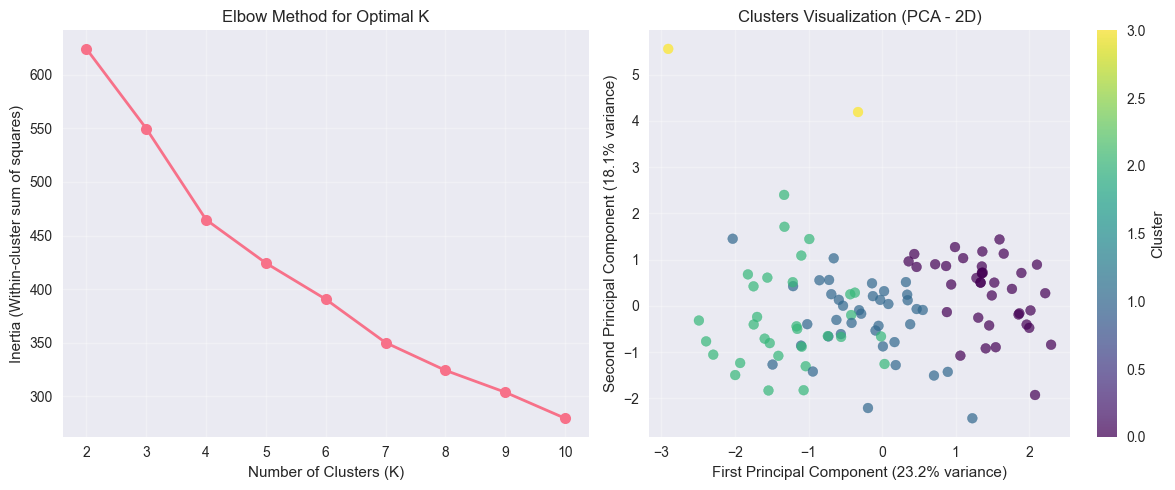


PCA explained variance ratio: [0.23189833 0.18055129]
Total variance explained: 41.2%


In [74]:
# Prepare data for clustering
print("🧺 Clustering Analysis")
print("=" * 50)

# Create features for clustering
clustering_data = df.copy()

# Encode categorical variables
le_profession = LabelEncoder()
le_degree = LabelEncoder()
le_field = LabelEncoder()
le_country = LabelEncoder()

# Handle missing values and encode
clustering_data['Profession_Encoded'] = le_profession.fit_transform(clustering_data['Profession'].fillna('Unknown'))
clustering_data['Degree_Encoded'] = le_degree.fit_transform(clustering_data['Degree'].fillna('Unknown'))
clustering_data['Field_Encoded'] = le_field.fit_transform(clustering_data['Field'].fillna('Unknown'))
clustering_data['Country_Encoded'] = le_country.fit_transform(clustering_data['Country'].fillna('Unknown'))

# Fill missing numerical values with median (using correct column names)
clustering_data['Graduation_Year_Filled'] = clustering_data['Graduation_Year'].fillna(
    clustering_data['Graduation_Year'].median())
clustering_data['GPA_Filled'] = clustering_data['GPA'].fillna(
    clustering_data['GPA'].median())
clustering_data['University_Ranking_Filled'] = clustering_data['University_Ranking'].fillna(
    clustering_data['University_Ranking'].median())

# Select features for clustering
features_for_clustering = [
    'Profession_Encoded', 'Degree_Encoded', 'Field_Encoded', 'Country_Encoded',
    'Graduation_Year_Filled', 'GPA_Filled', 'University_Ranking_Filled'
]

X = clustering_data[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features prepared for clustering: {len(features_for_clustering)}")
print(f"Sample size: {X_scaled.shape[0]} individuals")

# Determine optimal number of clusters using elbow method
print("\n📈 Finding Optimal Number of Clusters")
print("-" * 40)

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True, alpha=0.3)

# Perform clustering with optimal K (let's use K=4 based on typical patterns)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
clustering_data['Cluster'] = clusters

print(f"\nClustering completed with K={optimal_k}")
print(f"Cluster distribution:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(clusters)) * 100
    print(f"  Cluster {cluster}: {count} individuals ({percentage:.1f}%)")

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7, s=50)
plt.title(f'Clusters Visualization (PCA - 2D)')
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.1%}")

## 7. Segment Analysis

### Detailed Cluster Profiling and Interpretation
Analyzing the characteristics of each cluster to understand different educational pathways to success.

🎯 Cluster Profiling and Segment Analysis

📈 CLUSTER 0 PROFILE (37 individuals)
💼 Top Professions:
  • Entrepreneur: 11 (29.7%)
  • Tech Executive: 4 (10.8%)
  • Tech CEO: 4 (10.8%)
  • Finance: 3 (8.1%)
  • Politician: 2 (5.4%)

🎓 Top Degrees:
  • Master: 12 (32.4%)
  • PhD: 7 (18.9%)
  • MBA: 7 (18.9%)

📚 Top Fields of Study:
  • Computer Science: 7 (18.9%)
  • Business: 7 (18.9%)
  • Economics: 3 (8.1%)

🌍 Top Countries:
  • USA: 33 (89.2%)
  • UK: 1 (2.7%)
  • Germany: 1 (2.7%)

📊 Numerical Characteristics:
  • Average graduation year: 1986
  • Average GPA: 3.87
  • Average university ranking: 18

⭐ Notable Individuals:
  Sundar Pichai, Sheryl Sandberg, Tim Cook, Sergey Brin, Larry Page, Stephen Hawking, Morgan Freeman, Kamala Harris
--------------------------------------------------

📈 CLUSTER 1 PROFILE (38 individuals)
💼 Top Professions:
  • Entrepreneur: 9 (23.7%)
  • Actor: 3 (7.9%)
  • Business Executive: 3 (7.9%)
  • Actor/Comedian: 2 (5.3%)
  • Media Executive: 2 (5.3%)

🎓 To

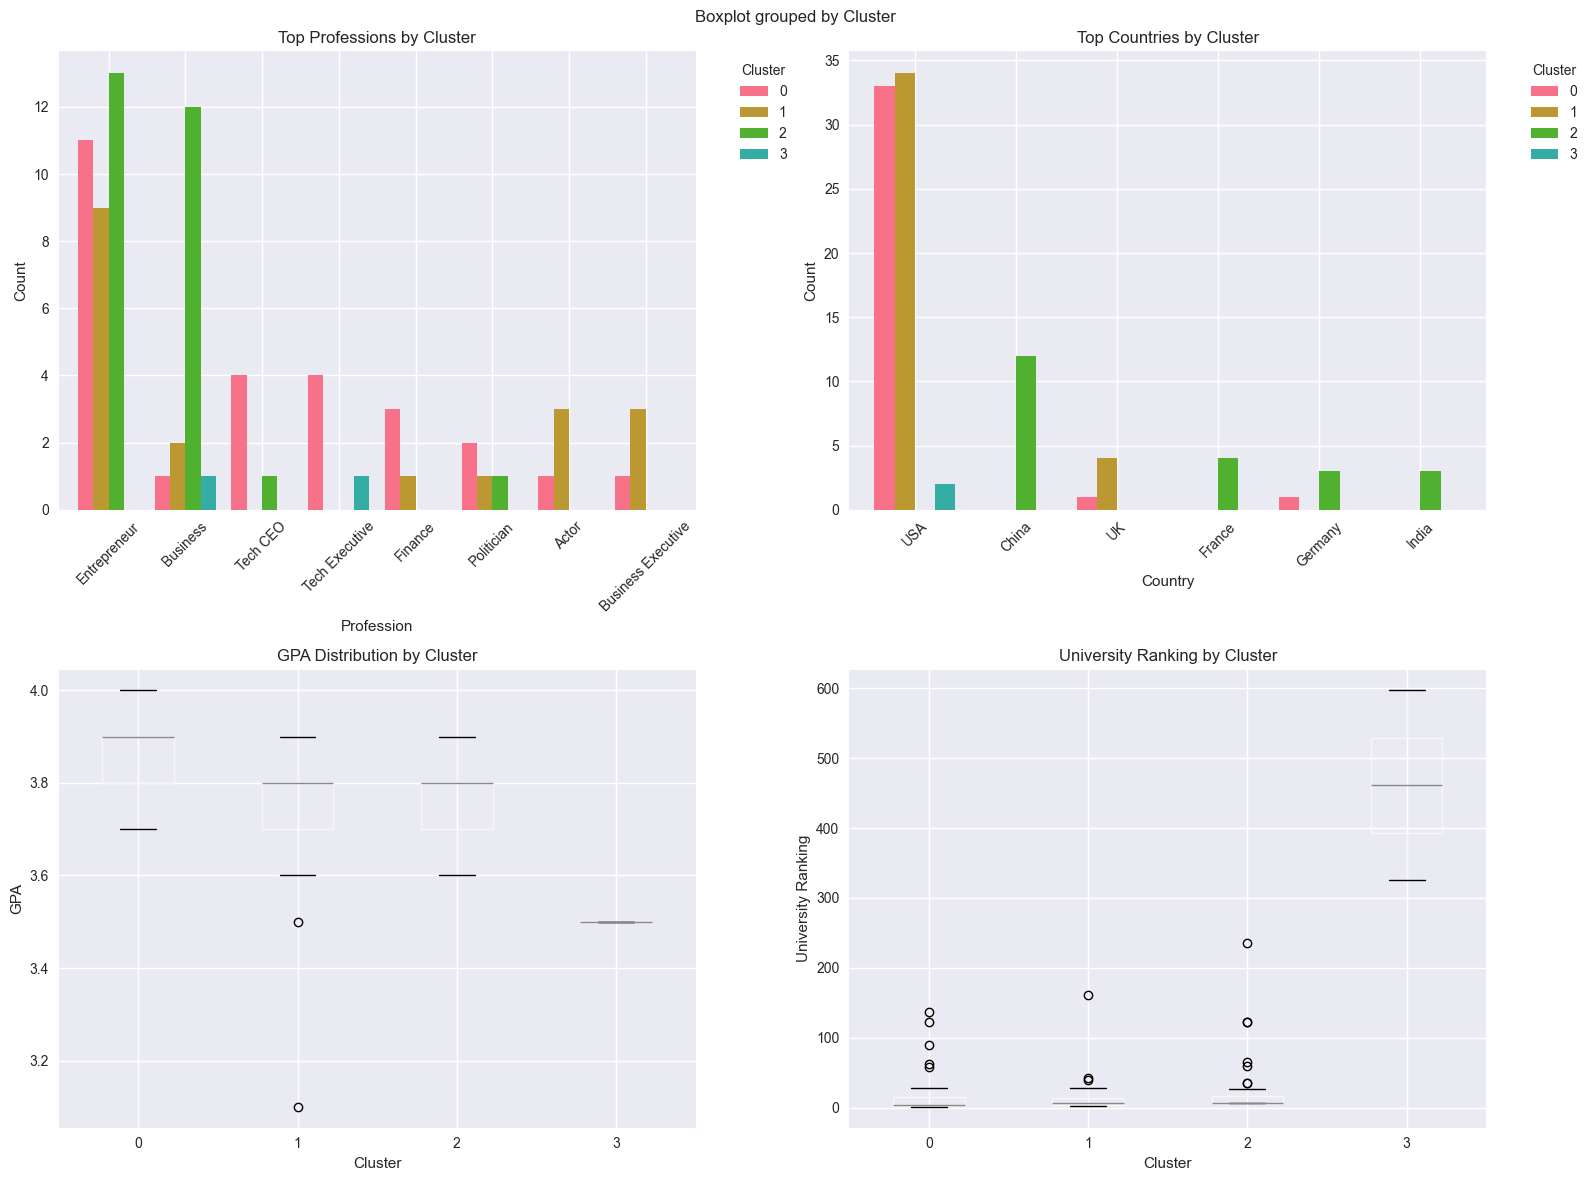

In [75]:
# Segment analysis - Profile each cluster
print("🎯 Cluster Profiling and Segment Analysis")
print("=" * 60)

# Create cluster profiles
for cluster_id in range(optimal_k):
    cluster_data = clustering_data[clustering_data['Cluster'] == cluster_id]
    print(f"\n📈 CLUSTER {cluster_id} PROFILE ({len(cluster_data)} individuals)")
    print("=" * 50)
    
    # Top professions in this cluster
    print("💼 Top Professions:")
    profession_dist = cluster_data['Profession'].value_counts().head(5)
    for prof, count in profession_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"  • {prof}: {count} ({percentage:.1f}%)")
    
    # Top degrees
    print("\n🎓 Top Degrees:")
    degree_dist = cluster_data['Degree'].value_counts().head(3)
    for degree, count in degree_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"  • {degree}: {count} ({percentage:.1f}%)")
    
    # Top fields of study
    print("\n📚 Top Fields of Study:")
    field_dist = cluster_data['Field'].value_counts().head(3)
    for field, count in field_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"  • {field}: {count} ({percentage:.1f}%)")
    
    # Top countries
    print("\n🌍 Top Countries:")
    country_dist = cluster_data['Country'].value_counts().head(3)
    for country, count in country_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"  • {country}: {count} ({percentage:.1f}%)")
    
    # Statistical summary for numerical features
    print("\n📊 Numerical Characteristics:")
    if cluster_data['Graduation_Year_Filled'].notna().sum() > 0:
        avg_grad_year = cluster_data['Graduation_Year_Filled'].mean()
        print(f"  • Average graduation year: {avg_grad_year:.0f}")
    
    if cluster_data['GPA_Filled'].notna().sum() > 0:
        avg_gpa = cluster_data['GPA_Filled'].mean()
        print(f"  • Average GPA: {avg_gpa:.2f}")
    
    if cluster_data['University_Ranking_Filled'].notna().sum() > 0:
        avg_ranking = cluster_data['University_Ranking_Filled'].mean()
        print(f"  • Average university ranking: {avg_ranking:.0f}")
    
    # Notable individuals in this cluster
    print("\n⭐ Notable Individuals:")
    sample_names = cluster_data['Name'].head(8).tolist()
    print(f"  {', '.join(sample_names)}")
    
    print("-" * 50)

# Cluster comparison visualization
print("\n📉 Cluster Comparison Visualization")
print("=" * 40)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cluster Analysis - Educational Profiles', fontsize=16, fontweight='bold')

# 1. Profession distribution by cluster
prof_cluster = pd.crosstab(clustering_data['Profession'], clustering_data['Cluster'])
top_professions = clustering_data['Profession'].value_counts().head(8).index
prof_cluster_filtered = prof_cluster.loc[top_professions]

prof_cluster_filtered.plot(kind='bar', ax=axes[0, 0], width=0.8)
axes[0, 0].set_title('Top Professions by Cluster')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Country distribution by cluster
country_cluster = pd.crosstab(clustering_data['Country'], clustering_data['Cluster'])
top_countries = clustering_data['Country'].value_counts().head(6).index
country_cluster_filtered = country_cluster.loc[top_countries]

country_cluster_filtered.plot(kind='bar', ax=axes[0, 1], width=0.8)
axes[0, 1].set_title('Top Countries by Cluster')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. GPA distribution by cluster
clustering_data.boxplot(column='GPA_Filled', by='Cluster', ax=axes[1, 0])
axes[1, 0].set_title('GPA Distribution by Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('GPA')

# 4. University ranking distribution by cluster
clustering_data.boxplot(column='University_Ranking_Filled', by='Cluster', ax=axes[1, 1])
axes[1, 1].set_title('University Ranking by Cluster')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('University Ranking')

plt.tight_layout()
plt.show()

## 8. Natural Language Processing

### Text Analysis of Educational Fields and Institutions
Analyzing textual data to extract insights from fields of study, institutions, and awards.

📝 Natural Language Processing Analysis
📈 Word Frequency Analysis
------------------------------
Top 20 most frequent words:
 1. award                |  21 occurrences
 2. science              |  20 occurrences
 3. engineering          |  18 occurrences
 4. computer             |  17 occurrences
 5. business             |  16 occurrences
 6. harvard              |  15 occurrences
 7. economics            |  12 occurrences
 8. merit                |  12 occurrences
 9. fellowship           |  10 occurrences
10. scholar              |  10 occurrences
11. excellence           |  10 occurrences
12. research             |  10 occurrences
13. stanford             |   9 occurrences
14. scholarship          |   8 occurrences
15. academic             |   8 occurrences
16. law                  |   8 occurrences
17. english              |   6 occurrences
18. honorary             |   5 occurrences
19. medicine             |   5 occurrences
20. grant                |   5 occurrences

🎓 Field of Stud

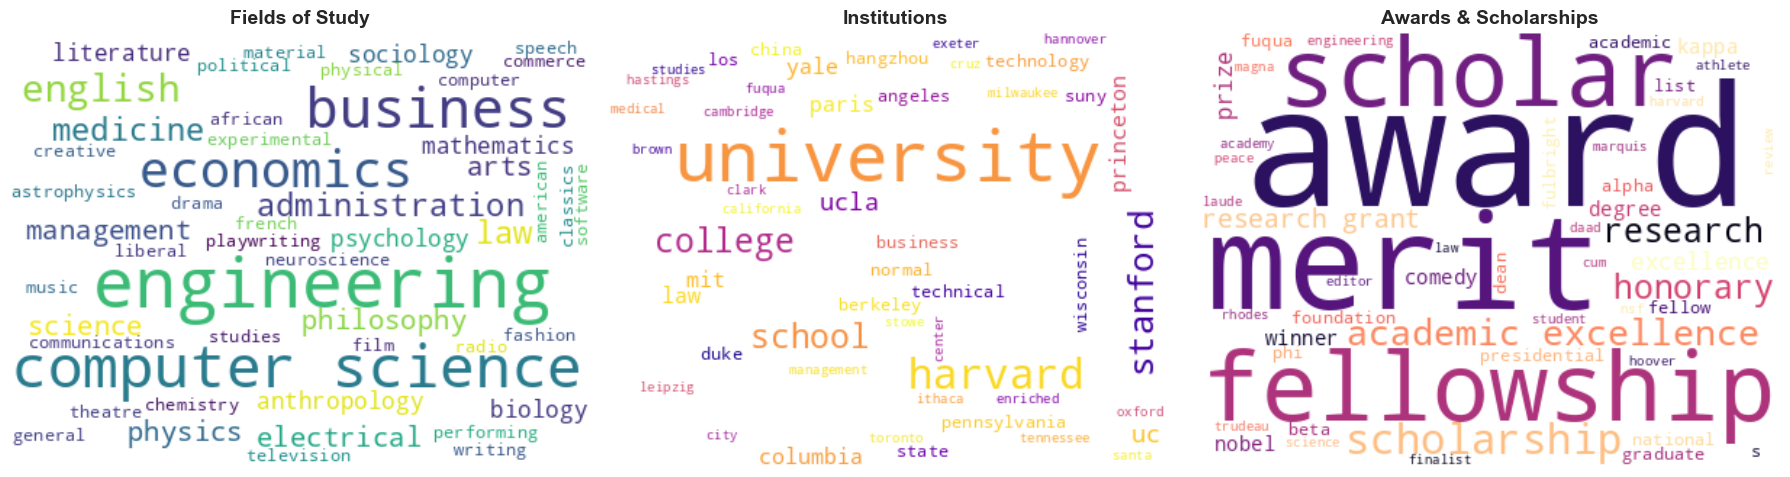

In [76]:
# Natural Language Processing Analysis
print("📝 Natural Language Processing Analysis")
print("=" * 60)

# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text) or text == 'N/A':
        return ""
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Combine relevant text fields for analysis
text_fields = ['Field', 'Institution', 'Scholarship/Award']
combined_text = []

for _, row in df.iterrows():
    row_text = []
    for field in text_fields:
        if field in df.columns:
            processed = preprocess_text(row[field])
            if processed:
                row_text.append(processed)
    combined_text.append(' '.join(row_text))

df['Combined_Text'] = combined_text

# Word frequency analysis
print("📈 Word Frequency Analysis")
print("-" * 30)

all_text = ' '.join(combined_text)
words = all_text.split()
word_freq = Counter(words)

# Remove common stop words
stop_words = {'and', 'or', 'the', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 
              'university', 'college', 'school', 'degree', 'bachelor', 'master', 'phd'}
filtered_word_freq = {word: freq for word, freq in word_freq.items() 
                     if word not in stop_words and len(word) > 2}

print("Top 20 most frequent words:")
for i, (word, freq) in enumerate(sorted(filtered_word_freq.items(), 
                                      key=lambda x: x[1], reverse=True)[:20], 1):
    print(f"{i:2d}. {word:<20} | {freq:3d} occurrences")

# Field of study analysis
print("\n🎓 Field of Study Analysis")
print("-" * 30)

fields_clean = [preprocess_text(field) for field in df['Field'].dropna()]
field_words = ' '.join(fields_clean).split()
field_word_freq = Counter(field_words)

# Remove stop words from field analysis
filtered_field_freq = {word: freq for word, freq in field_word_freq.items() 
                      if word not in stop_words and len(word) > 2}

print("Top fields/subjects of study:")
for i, (word, freq) in enumerate(sorted(filtered_field_freq.items(), 
                                      key=lambda x: x[1], reverse=True)[:15], 1):
    print(f"{i:2d}. {word:<20} | {freq:3d} mentions")

# Institution analysis
print("\n🏢 Institution Name Analysis")
print("-" * 30)

institutions_clean = [preprocess_text(inst) for inst in df['Institution'].dropna()]
inst_words = ' '.join(institutions_clean).split()
inst_word_freq = Counter(inst_words)

# Filter institution words
filtered_inst_freq = {word: freq for word, freq in inst_word_freq.items() 
                     if word not in stop_words and len(word) > 3}

print("Most common words in institution names:")
for i, (word, freq) in enumerate(sorted(filtered_inst_freq.items(), 
                                      key=lambda x: x[1], reverse=True)[:10], 1):
    print(f"{i:2d}. {word:<20} | {freq:3d} mentions")

# Create word clouds
print("\n📄 Word Cloud Visualizations")
print("-" * 30)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Word cloud for fields of study
if field_words:
    field_text = ' '.join(fields_clean)
    if field_text.strip():
        wordcloud_fields = WordCloud(width=400, height=300, background_color='white',
                                    max_words=50, colormap='viridis').generate(field_text)
        axes[0].imshow(wordcloud_fields, interpolation='bilinear')
        axes[0].set_title('Fields of Study', fontsize=14, fontweight='bold')
        axes[0].axis('off')

# Word cloud for institutions
if institutions_clean:
    inst_text = ' '.join(institutions_clean)
    if inst_text.strip():
        wordcloud_inst = WordCloud(width=400, height=300, background_color='white',
                                  max_words=50, colormap='plasma').generate(inst_text)
        axes[1].imshow(wordcloud_inst, interpolation='bilinear')
        axes[1].set_title('Institutions', fontsize=14, fontweight='bold')
        axes[1].axis('off')

# Word cloud for awards/scholarships
awards_clean = [preprocess_text(award) for award in df['Scholarship/Award'].dropna()]
if awards_clean:
    awards_text = ' '.join(awards_clean)
    if awards_text.strip():
        wordcloud_awards = WordCloud(width=400, height=300, background_color='white',
                                   max_words=50, colormap='magma').generate(awards_text)
        axes[2].imshow(wordcloud_awards, interpolation='bilinear')
        axes[2].set_title('Awards & Scholarships', fontsize=14, fontweight='bold')
        axes[2].axis('off')

plt.tight_layout()
plt.show()

## 9. Graphs

Analyzing the data to extract graphs from fields of study, institutions, and awards.

📉 Creating Individual Visualization Charts
Creating Chart 1: Profession Distribution


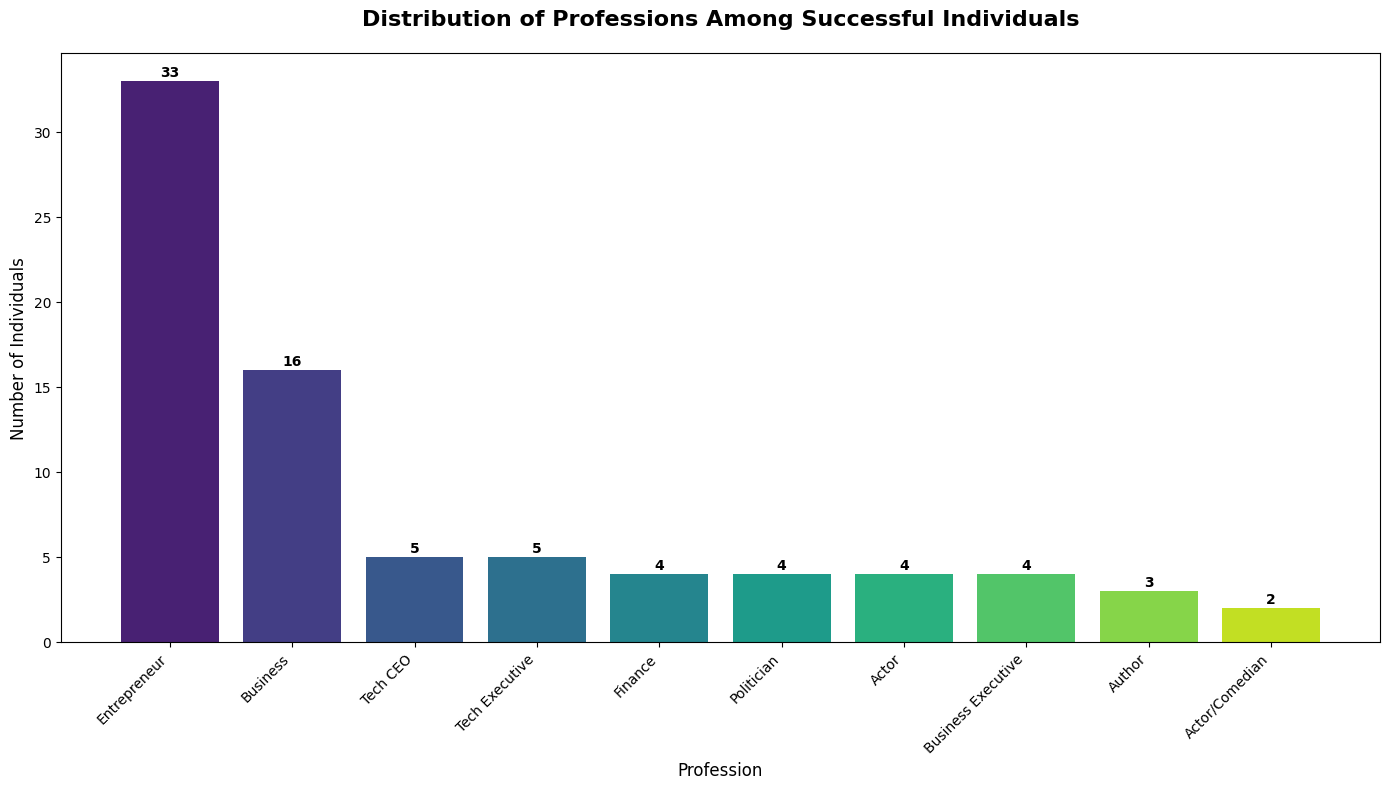

Creating Chart 2: Degree Types Distribution


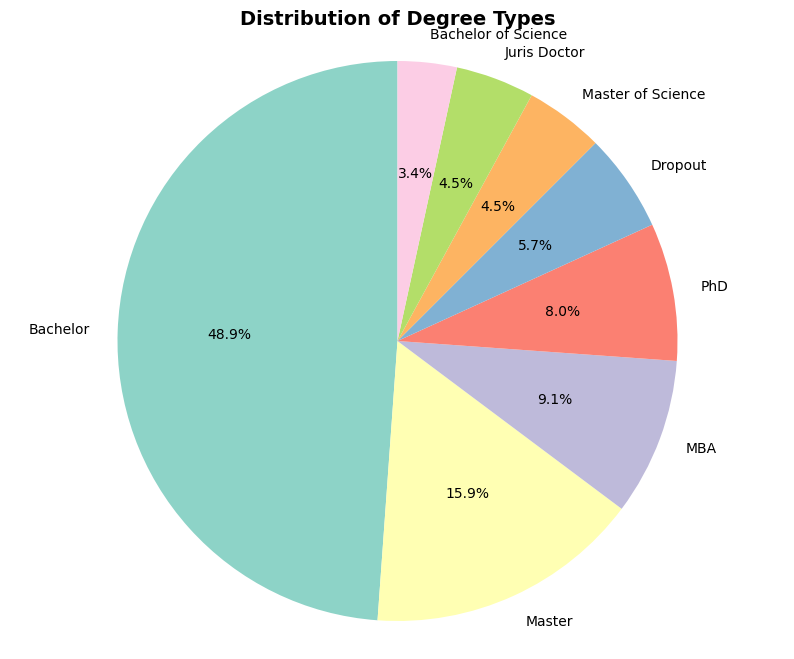

Creating Chart 3: Country Distribution


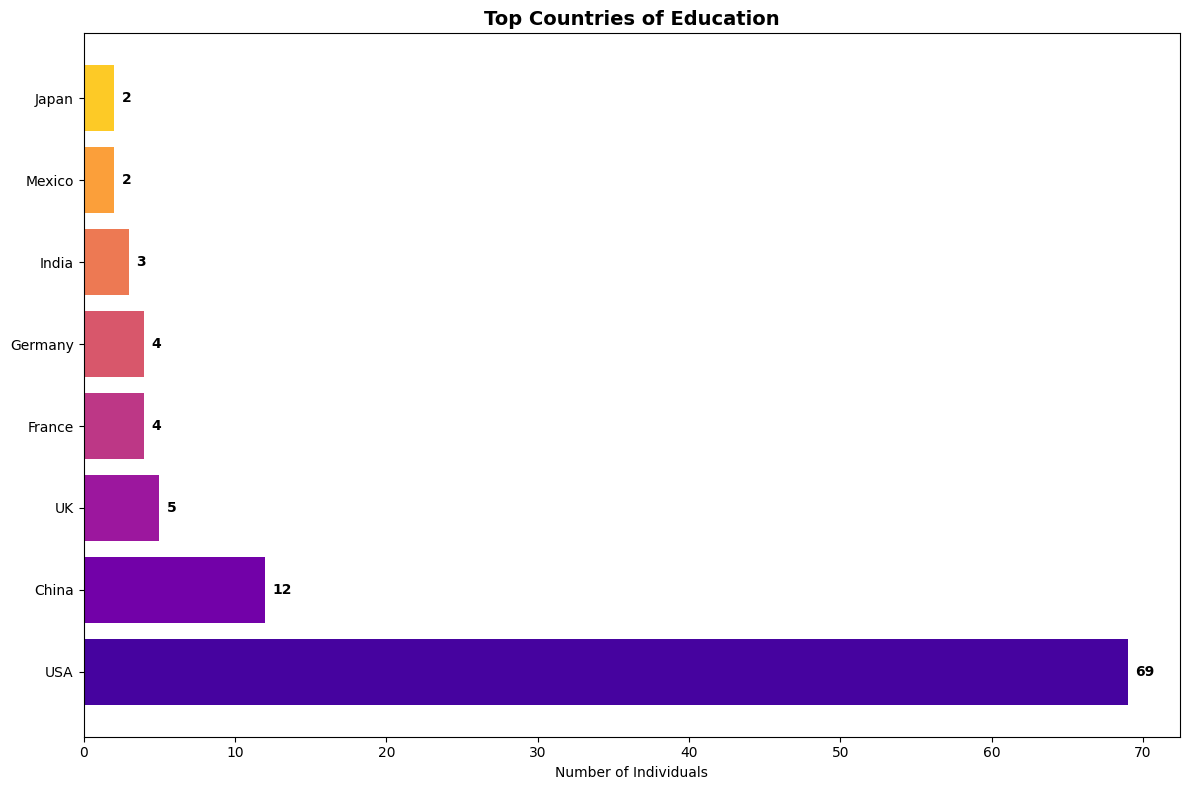

Creating Chart 4: University Ranking vs GPA


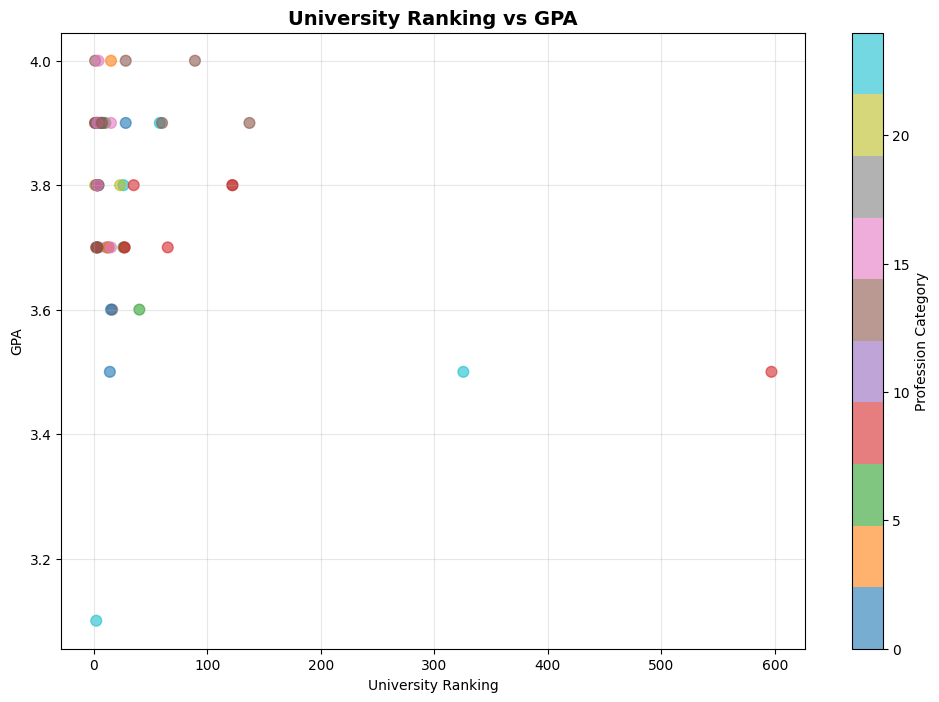

Creating Chart 5: Graduation Year Timeline


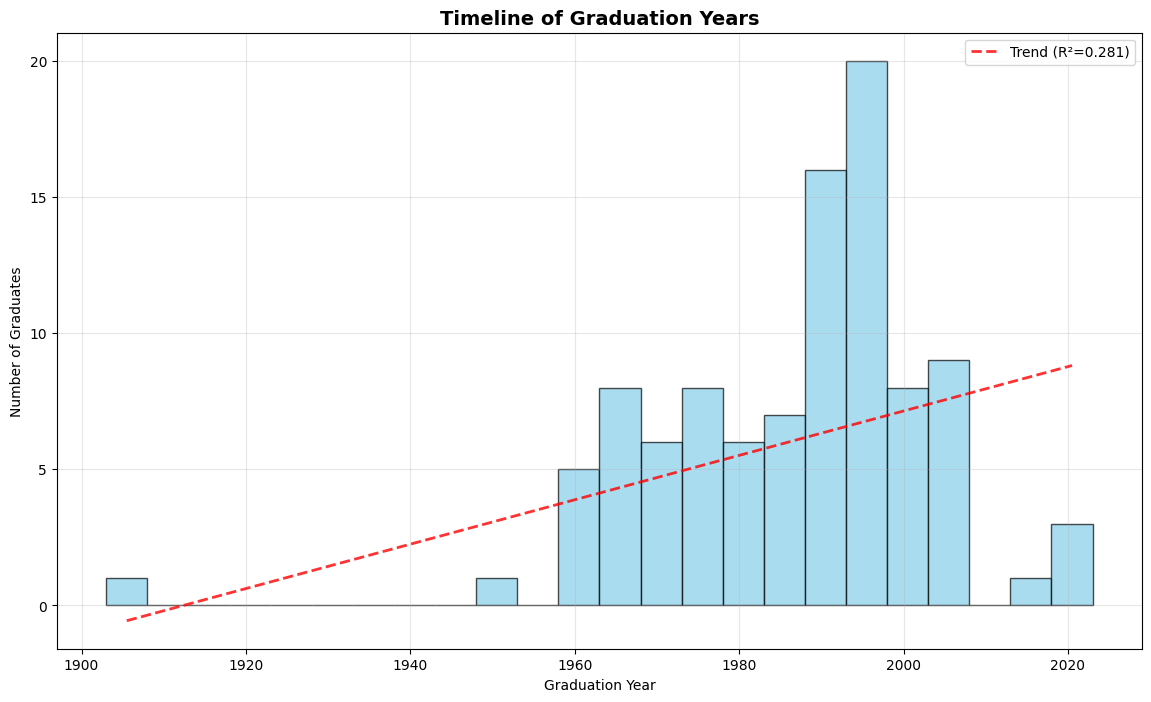

Creating Chart 6: Top Fields of Study


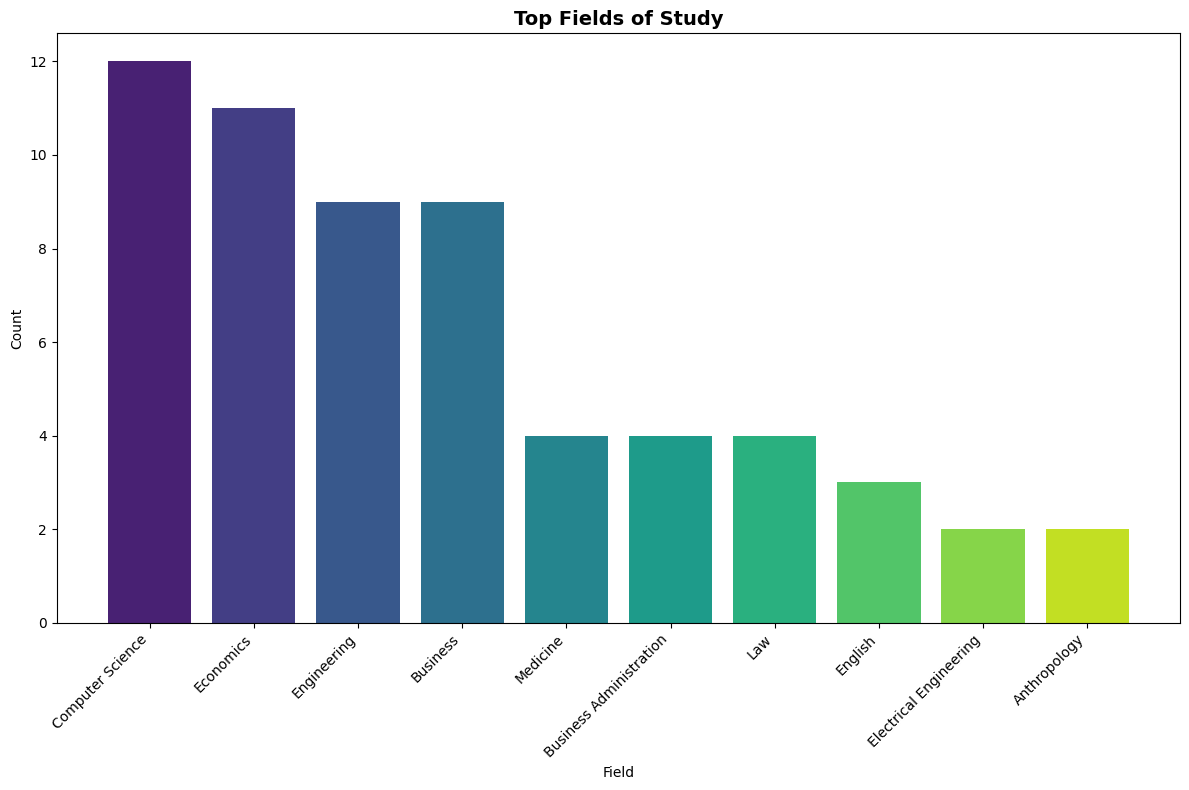

Creating Chart 7: GPA Distribution


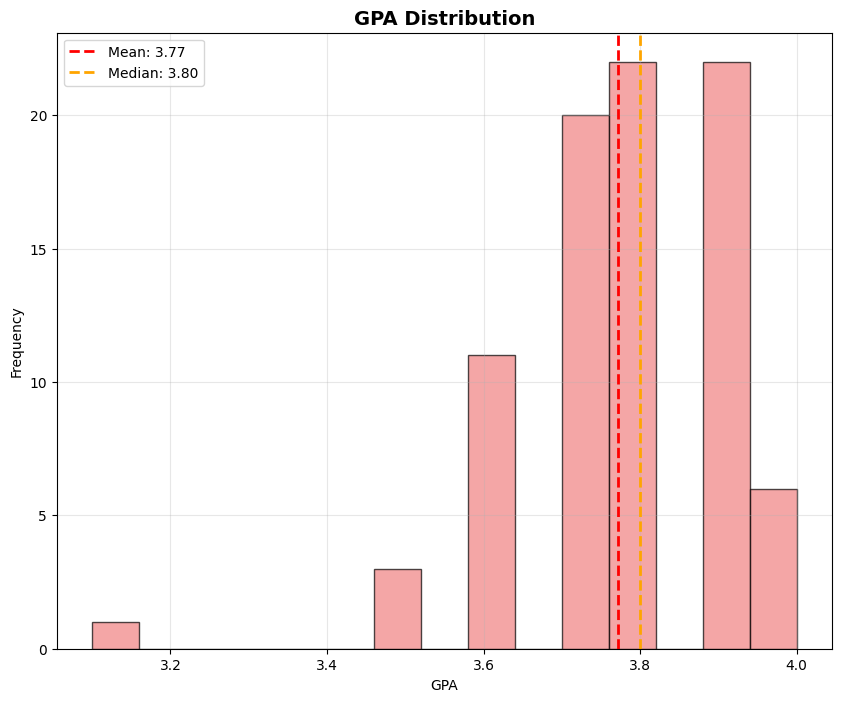

Creating Chart 8: University Ranking Distribution


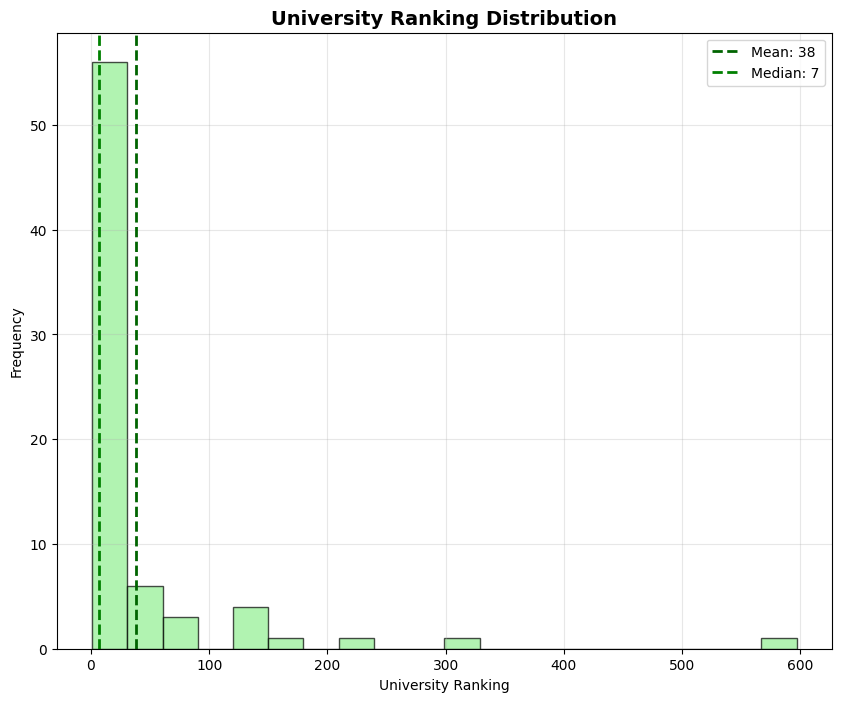

Creating Chart 9: Profession vs Country Heatmap


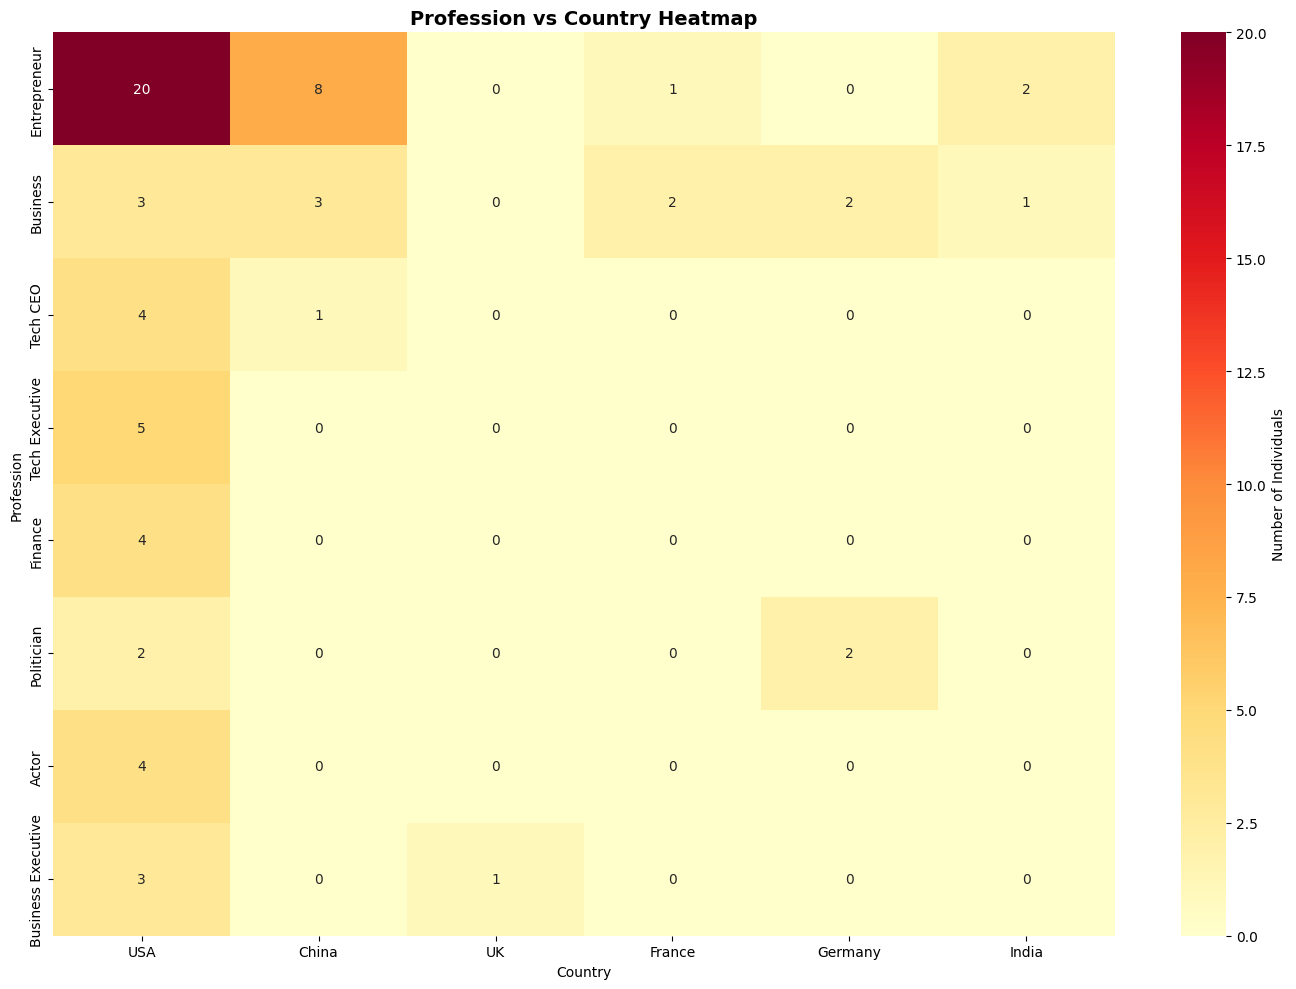

Creating Chart 11: Top Educational Institutions


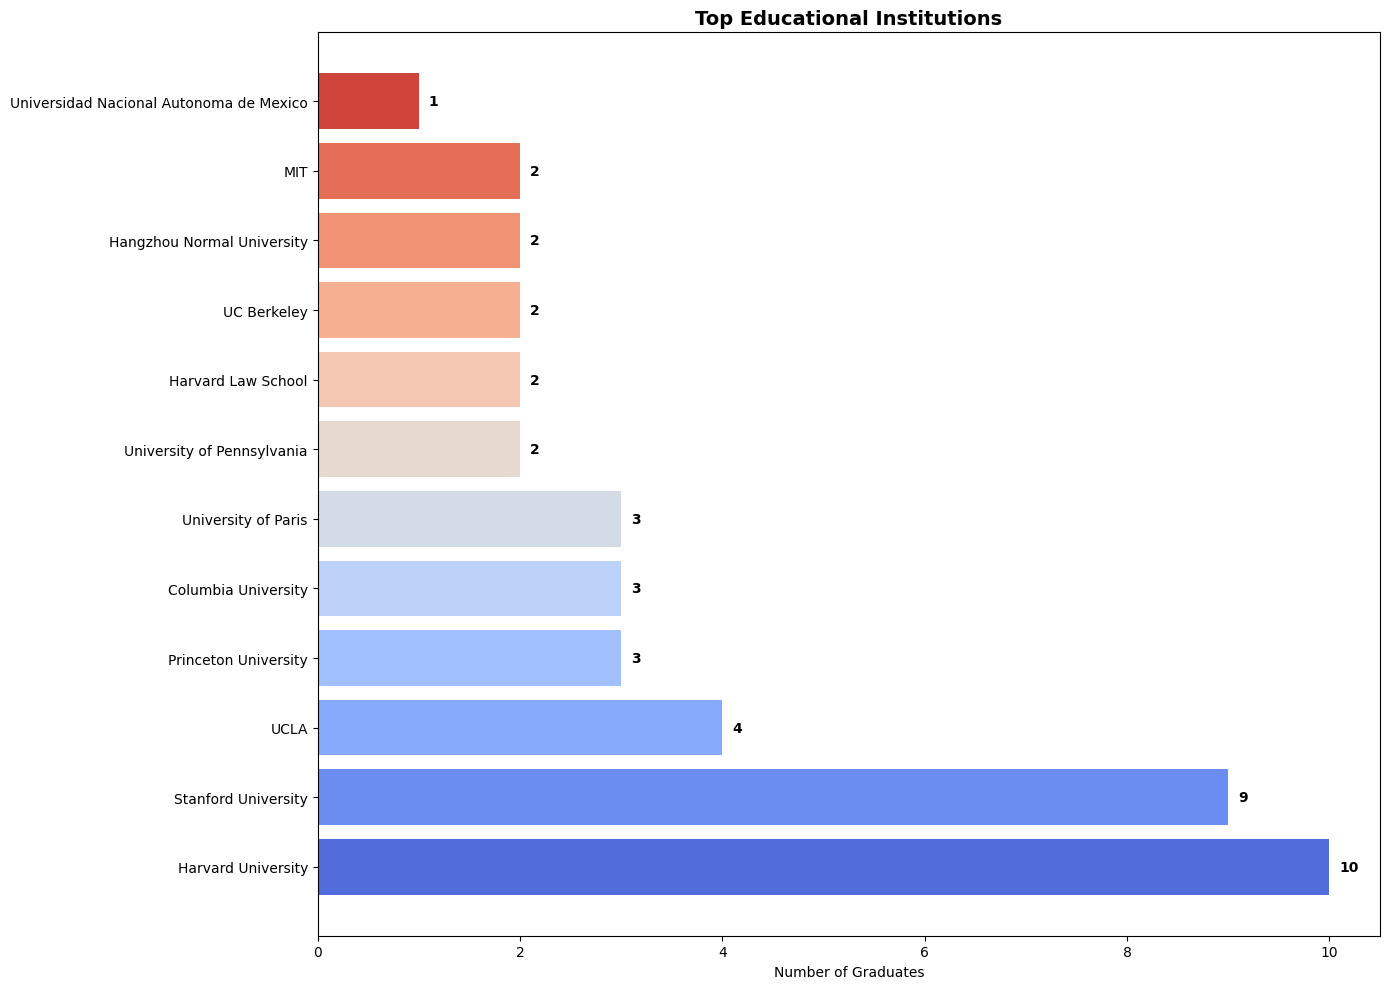

✅ All individual visualization charts created successfully!


In [77]:


# Comprehensive Visualizations - Individual Charts
print("📉 Creating Individual Visualization Charts")
print("=" * 60)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("Set2")

# 1. Profession Distribution (Top 10)
print("Creating Chart 1: Profession Distribution")
plt.figure(figsize=(14, 8))
top_professions = df['Profession'].value_counts().head(10)
bars1 = plt.bar(range(len(top_professions)), top_professions.values, 
                color=sns.color_palette("viridis", len(top_professions)))
plt.title('Distribution of Professions Among Successful Individuals', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Profession', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.xticks(range(len(top_professions)), top_professions.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Degree Types Distribution
print("Creating Chart 2: Degree Types Distribution")
plt.figure(figsize=(10, 8))
degree_counts = df['Degree'].value_counts().head(8)
wedges, texts, autotexts = plt.pie(degree_counts.values, labels=degree_counts.index, 
                                   autopct='%1.1f%%', startangle=90,
                                   colors=sns.color_palette("Set3", len(degree_counts)))
plt.title('Distribution of Degree Types', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

# 3. Country Distribution
print("Creating Chart 3: Country Distribution")
plt.figure(figsize=(12, 8))
country_counts = df['Country'].value_counts().head(8)
bars3 = plt.barh(range(len(country_counts)), country_counts.values,
                 color=sns.color_palette("plasma", len(country_counts)))
plt.title('Top Countries of Education', fontsize=14, fontweight='bold')
plt.xlabel('Number of Individuals')
plt.yticks(range(len(country_counts)), country_counts.index)

# Add value labels
for i, bar in enumerate(bars3):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. University Ranking vs GPA Scatter Plot
print("Creating Chart 4: University Ranking vs GPA")
plt.figure(figsize=(12, 8))
valid_data = df.dropna(subset=['University_Ranking', 'GPA'])
if not valid_data.empty:
    scatter = plt.scatter(valid_data['University_Ranking'], 
                         valid_data['GPA'],
                         c=valid_data['Profession'].astype('category').cat.codes,
                         alpha=0.6, s=60, cmap='tab10')
    plt.xlabel('University Ranking')
    plt.ylabel('GPA')
    plt.title('University Ranking vs GPA', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Profession Category')
plt.show()

# 5. Graduation Year Timeline
print("Creating Chart 5: Graduation Year Timeline")
plt.figure(figsize=(14, 8))
valid_years = df.dropna(subset=['Graduation_Year'])
if not valid_years.empty:
    # Create histogram of graduation years
    bins = range(int(valid_years['Graduation_Year'].min()), 
                 int(valid_years['Graduation_Year'].max()) + 5, 5)
    n, bins, patches = plt.hist(valid_years['Graduation_Year'], bins=bins, 
                               alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Timeline of Graduation Years', fontsize=14, fontweight='bold')
    plt.xlabel('Graduation Year')
    plt.ylabel('Number of Graduates')
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    from scipy import stats
    bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    slope, intercept, r_value, p_value, std_err = stats.linregress(bin_centers, n)
    line = slope * np.array(bin_centers) + intercept
    plt.plot(bin_centers, line, 'r--', alpha=0.8, linewidth=2, 
             label=f'Trend (R²={r_value**2:.3f})')
    plt.legend()
plt.show()

# 6. Top Fields of Study
print("Creating Chart 6: Top Fields of Study")
plt.figure(figsize=(12, 8))
field_counts = df['Field'].value_counts().head(10)
bars6 = plt.bar(range(len(field_counts)), field_counts.values,
                color=sns.color_palette("viridis", len(field_counts)))
plt.title('Top Fields of Study', fontsize=14, fontweight='bold')
plt.xlabel('Field')
plt.ylabel('Count')
plt.xticks(range(len(field_counts)), field_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. GPA Distribution
print("Creating Chart 7: GPA Distribution")
plt.figure(figsize=(10, 8))
valid_gpa = df['GPA'].dropna()
if not valid_gpa.empty:
    plt.hist(valid_gpa, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.axvline(valid_gpa.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {valid_gpa.mean():.2f}')
    plt.axvline(valid_gpa.median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {valid_gpa.median():.2f}')
    plt.title('GPA Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('GPA')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.show()

# 8. University Ranking Distribution
print("Creating Chart 8: University Ranking Distribution")
plt.figure(figsize=(10, 8))
valid_ranking = df['University_Ranking'].dropna()
if not valid_ranking.empty:
    plt.hist(valid_ranking, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(valid_ranking.mean(), color='darkgreen', linestyle='--', linewidth=2,
                label=f'Mean: {valid_ranking.mean():.0f}')
    plt.axvline(valid_ranking.median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {valid_ranking.median():.0f}')
    plt.title('University Ranking Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('University Ranking')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.show()

# 9. Profession vs Country Heatmap
print("Creating Chart 9: Profession vs Country Heatmap")
plt.figure(figsize=(14, 10))
top_professions_countries = pd.crosstab(df['Profession'], df['Country'])
# Filter to top professions and countries
top_prof = df['Profession'].value_counts().head(8).index
top_countries = df['Country'].value_counts().head(6).index
heatmap_data = top_professions_countries.loc[top_prof, top_countries]

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='d',
           cbar_kws={'label': 'Number of Individuals'})
plt.title('Profession vs Country Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Country')
plt.ylabel('Profession')
plt.tight_layout()
plt.show()

# 10. Cluster Visualization (if clustering was performed)
if 'Cluster' in df.columns:
    print("Creating Chart 10: Cluster Distribution")
    plt.figure(figsize=(10, 8))
    cluster_counts = df['Cluster'].value_counts().sort_index()
    bars10 = plt.bar(cluster_counts.index, cluster_counts.values,
                      color=sns.color_palette("Set1", len(cluster_counts)))
    plt.title('Cluster Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Individuals')
    
    # Add value labels
    for bar in bars10:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    plt.show()

# 11. Top Institutions
print("Creating Chart 11: Top Educational Institutions")
plt.figure(figsize=(14, 10))
top_institutions = df['Institution'].value_counts().head(12)
bars11 = plt.barh(range(len(top_institutions)), top_institutions.values,
                   color=sns.color_palette("coolwarm", len(top_institutions)))
plt.title('Top Educational Institutions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Graduates')
plt.yticks(range(len(top_institutions)), top_institutions.index)

# Add value labels
for i, bar in enumerate(bars11):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ All individual visualization charts created successfully!")

## 10. Model Building

### Comprehensive Machine Learning Analysis
Implementing both supervised and unsupervised learning models to extract insights and make predictions from the educational success dataset.

✅ Libraries for modeling imported successfully!

📋 Preparing Data for Machine Learning
----------------------------------------

📊 Profession Categories Distribution:
  • Business/Finance              :  63 ( 58.3%)
  • Media/Arts/Entertainment      :  22 ( 20.4%)
  • Technology/Engineering        :  10 (  9.3%)
  • Politics/Law/Activism         :   5 (  4.6%)
  • Other                         :   5 (  4.6%)
  • Science/Research              :   3 (  2.8%)

✅ Data prepared for modeling: 108 samples, 23 features (including intermediate ones)
Training set: 75 samples
Test set: 33 samples
Number of features: 7
Number of classes: 6

📈 Model Training and Evaluation:
--------------------------------------------------

🔸 Training Logistic Regression...
  Accuracy: 0.364
  F1-Score (weighted): 0.380
  CV F1-Score (weighted): 0.454 (±0.051)

🔸 Training Random Forest...
  Accuracy: 0.636
  F1-Score (weighted): 0.556
  CV F1-Score (weighted): 0.518 (±0.027)

🔸 Training Gradient Boosting...
  Accu

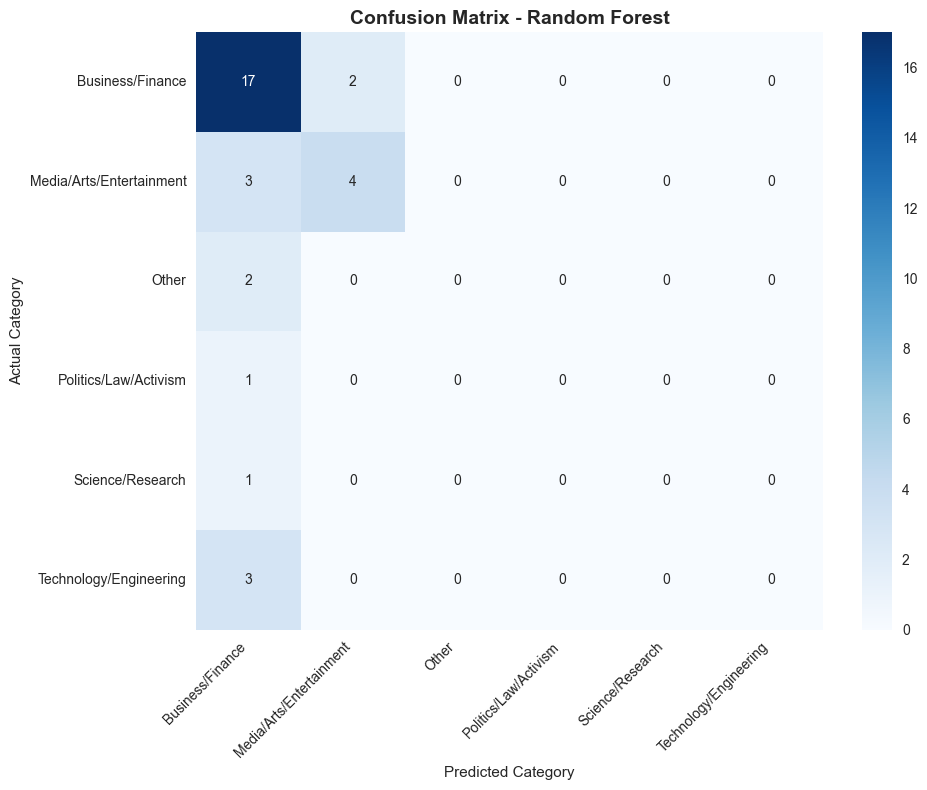


📈 Detailed Classification Report:
                          precision    recall  f1-score   support

        Business/Finance       0.63      0.89      0.74        19
Media/Arts/Entertainment       0.67      0.57      0.62         7
                   Other       0.00      0.00      0.00         2
   Politics/Law/Activism       0.00      0.00      0.00         1
        Science/Research       0.00      0.00      0.00         1
  Technology/Engineering       0.00      0.00      0.00         3

                accuracy                           0.64        33
               macro avg       0.22      0.24      0.23        33
            weighted avg       0.50      0.64      0.56        33


🔬 Feature Importance Analysis:
Feature importance ranking:
                      Feature  Importance
4     Graduation_Year_Numeric    0.191430
1               Field_Encoded    0.181306
0              Degree_Encoded    0.177060
3   Scholarship/Award_Encoded    0.165996
6  University_Ranking_Numeric   

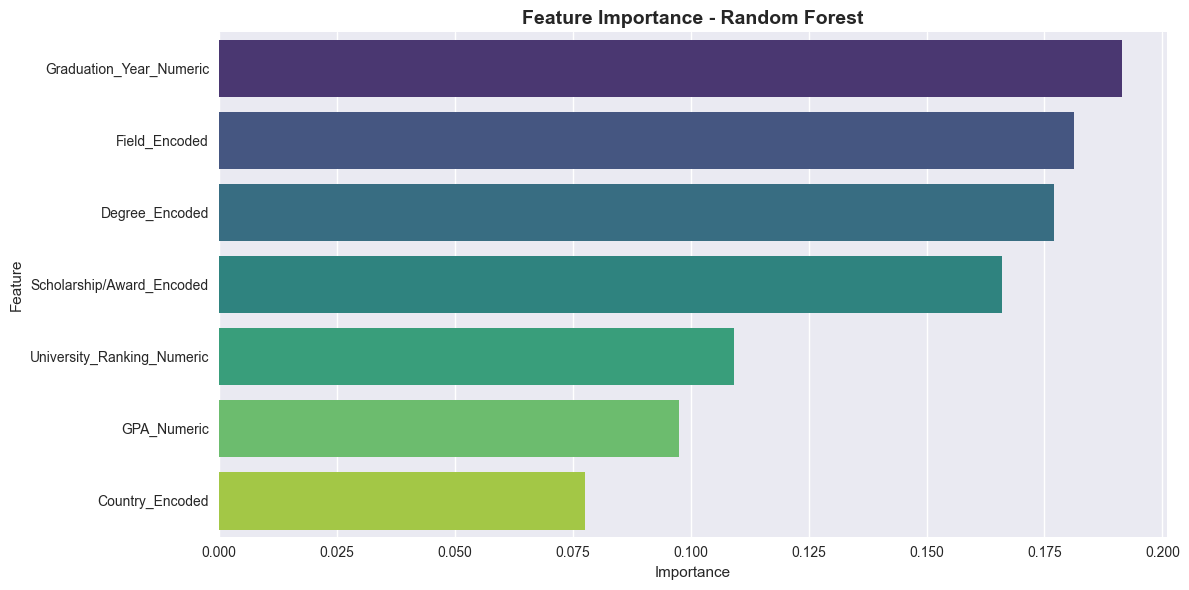

Clustering dataset: 108 samples, 7 features

🔸 Comparing Clustering Algorithms:
----------------------------------------

📊 K-Means Clustering:
  Number of clusters found: 4
  Number of noise points: 0 (for DBSCAN)
  Silhouette Score: 0.214
  Cluster sizes: {np.int32(0): np.int64(44), np.int32(1): np.int64(29), np.int32(2): np.int64(33), np.int32(3): np.int64(2)}

📊 Agglomerative Clustering:
  Number of clusters found: 4
  Number of noise points: 0 (for DBSCAN)
  Silhouette Score: 0.199
  Cluster sizes: {np.int64(0): np.int64(60), np.int64(1): np.int64(27), np.int64(2): np.int64(5), np.int64(3): np.int64(16)}

📊 DBSCAN Clustering:
  Number of clusters found: 3
  Number of noise points: 40 (for DBSCAN)
  Silhouette Score: 0.064
  Cluster sizes: {np.int64(-1): np.int64(40), np.int64(0): np.int64(42), np.int64(1): np.int64(14), np.int64(2): np.int64(12)}

🏆 Best clustering algorithm (by Silhouette Score): K-Means (Silhouette Score: 0.214)

📈 Clustering Visualization (using PCA):


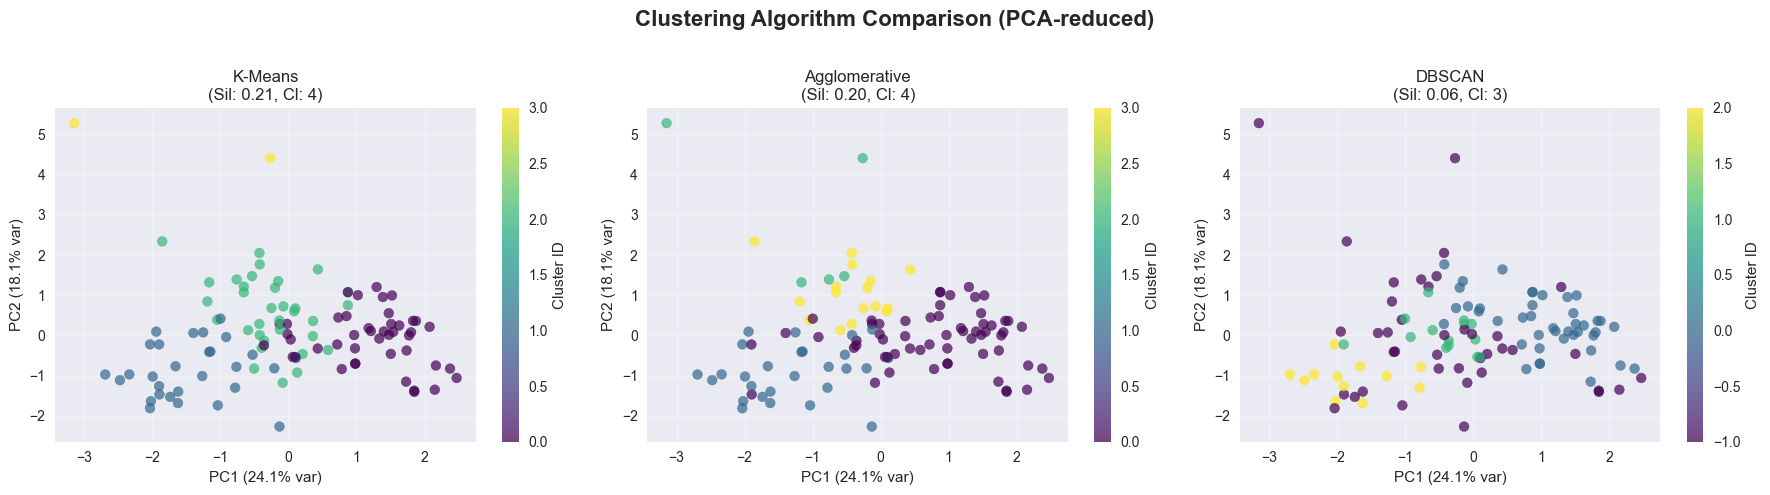


PCA Explained Variance (2 components): 42.3%
Regression dataset: 73 samples with valid university ranking data
Target variable (University Ranking) statistics:
  Mean: 38.0, Median: 7.0, Min: 1.0, Max: 597.0

📈 Regression Model Training and Evaluation:
--------------------------------------------------

🔸 Training Linear Regression...
  R² Score: -18.011
  RMSE: 128.9
  MAE: 95.5
  CV R² Score: -6.357 (±8.285)

🔸 Training Ridge...
  R² Score: -16.655
  RMSE: 124.2
  MAE: 92.2
  CV R² Score: -5.540 (±7.169)

🔸 Training Lasso...
  R² Score: -16.063
  RMSE: 122.1
  MAE: 90.4
  CV R² Score: -5.921 (±7.716)

🔸 Training Random Forest Regressor...
  R² Score: -4.787
  RMSE: 71.1
  MAE: 44.7
  CV R² Score: -6.707 (±9.257)

🔸 Training Gradient Boosting Regressor...
  R² Score: -1.990
  RMSE: 51.1
  MAE: 33.6
  CV R² Score: -9.616 (±13.214)

📊 Regression Model Comparison:
----------------------------------------------------------------------
Model                          R² Score   RMSE       

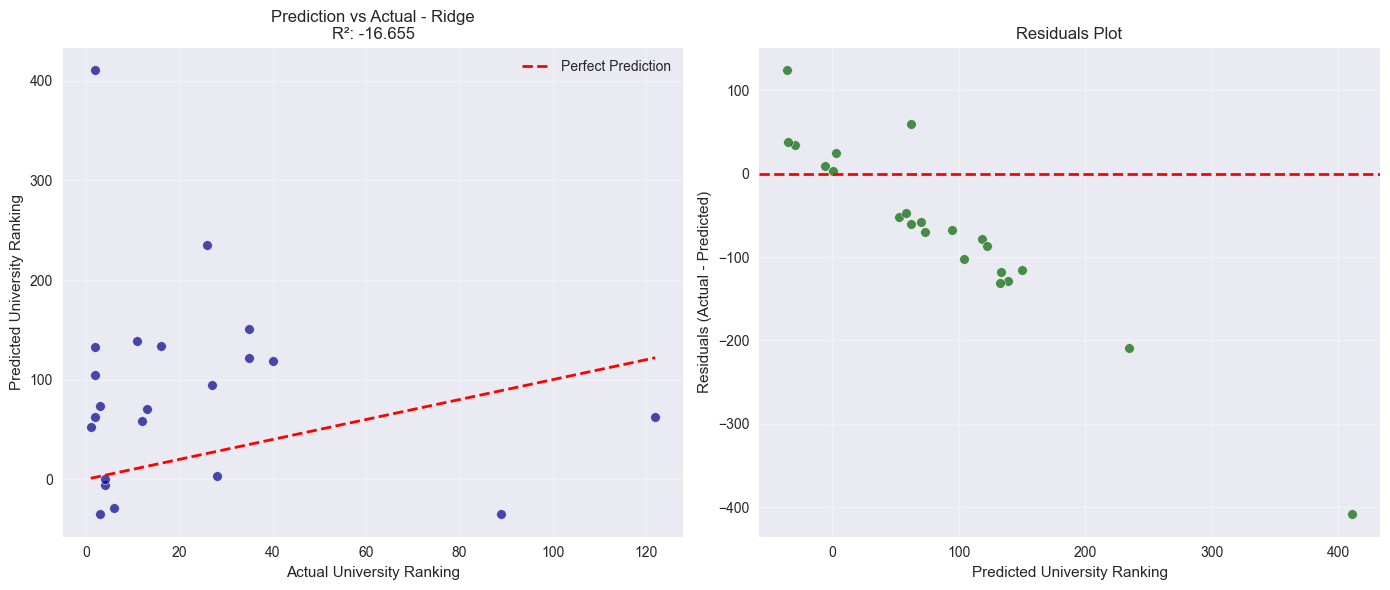


🧠 COMPREHENSIVE MODEL INSIGHTS AND INTERPRETATIONS

1️⃣ CLASSIFICATION MODEL INSIGHTS (Profession Category Prediction)
------------------------------------------------------------
🎯 Best Classification Model: Random Forest
   • Test Accuracy: 63.6%
   • Cross-validated F1-score (weighted): 0.518

🔍 Key Findings (Classification):
   📊 Most Important Features for Profession Prediction:
      1. Graduation_Year_Numeric: 0.191 importance
      2. Field_Encoded: 0.181 importance
      3. Degree_Encoded: 0.177 importance

   💡 Interpretation (Classification):
      • The model shows some capability in predicting profession categories from educational background.
      • 'Field of Study', 'Graduation Year', and 'University Ranking' appear to be influential factors.
      • Performance varies significantly across different profession categories, especially for underrepresented ones.

2️⃣ CLUSTERING MODEL INSIGHTS (K-Means)
------------------------------------------------------------
🎯 Best Cl

In [85]:
# %% [markdown]
# ## 10. Model Building
# 
# ### Comprehensive Machine Learning Analysis
# Implementing both supervised and unsupervised learning models to extract insights and make predictions from the educational success dataset.

# %%
# Imports for Model Building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    silhouette_score,
    mean_squared_error, r2_score, mean_absolute_error
)
# import joblib # For saving models, if needed
# import shap # For SHAP analysis, if enabled
# SHAP_AVAILABLE = False # Set to True if shap is installed and you want to run it

# Standard plot and warning settings (assuming these might have been set globally)
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8') # Or your preferred style
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Libraries for modeling imported successfully!")

# %%
print("\n📋 Preparing Data for Machine Learning")
print("-" * 40)

# Create a copy of the original DataFrame for modeling
ml_data = df.copy()

# --- Feature Cleaning and Engineering ---

# 1. Graduation Year
ml_data['Graduation_Year_Numeric'] = pd.to_numeric(ml_data['Graduation Year'], errors='coerce')

# 2. GPA
def clean_gpa_for_modeling(value):
    if pd.isna(value):
        return np.nan
    text_value = str(value).lower()
    if text_value in ['n/a', 'nan', 'dropped out', 'none']:
        return np.nan
    # Handle honorifics by assigning a high GPA or a specific mapping if desired
    # For now, let's try to extract numbers only and map common honorifics if needed.
    # This simple version tries to convert to float directly and handles common text.
    # It might need more robust parsing for edge cases like 'First Class Honours'.
    if 'first class honours' in text_value or 'summa cum laude' in text_value:
        return 4.0 # Example mapping
    if 'magna cum laude' in text_value:
        return 3.8 # Example mapping
    try:
        # Skip time formats like "02:02:00"
        if ':' in text_value:
            return np.nan
        return float(text_value)
    except ValueError:
        return np.nan
ml_data['GPA_Numeric'] = ml_data['GPA (or Equivalent)'].apply(clean_gpa_for_modeling)

# 3. University Global Ranking
def clean_ranking_for_modeling(value):
    if pd.isna(value) or str(value).lower() in ['n/a', 'nan']:
        return np.nan
    value_str = str(value)
    if '–' in value_str or '-' in value_str: # Handle ranges like "301–350"
        parts = re.split(r'[–-]', value_str)
        return (float(parts[0]) + float(parts[1])) / 2 if len(parts) == 2 else float(parts[0])
    try:
        return float(value_str)
    except ValueError:
        return np.nan
ml_data['University_Ranking_Numeric'] = ml_data['University Global Ranking'].apply(clean_ranking_for_modeling)

# --- Missing Value Imputation ---
numerical_cols_to_impute = ['Graduation_Year_Numeric', 'GPA_Numeric', 'University_Ranking_Numeric']
for col in numerical_cols_to_impute:
    ml_data[col] = ml_data[col].fillna(ml_data[col].median())

categorical_cols_to_impute = ['Profession', 'Degree', 'Field', 'Country', 'Scholarship/Award']
for col in categorical_cols_to_impute:
    ml_data[col] = ml_data[col].fillna('Unknown')

# --- Categorical Encoding ---
categorical_features_to_encode = ['Degree', 'Field', 'Country', 'Scholarship/Award'] # Profession handled separately for target
for col in categorical_features_to_encode:
    le = LabelEncoder()
    ml_data[f'{col}_Encoded'] = le.fit_transform(ml_data[col])
    # Storing encoders can be useful if you need to inverse_transform later
    # setattr(self, f'le_{col}', le) # If in a class context

# --- Target Variable for Classification: Profession Category ---
def categorize_profession(profession):
    profession_lower = str(profession).lower()
    if any(term in profession_lower for term in ['tech', 'computer', 'software', 'engineering related to tech']): # Broadened 'tech'
        return 'Technology/Engineering'
    if any(term in profession_lower for term in ['entrepreneur', 'ceo', 'founder', 'business', 'executive', 'leader', 'finance', 'investor']):
        return 'Business/Finance'
    if any(term in profession_lower for term in ['actor', 'media', 'musician', 'author', 'director', 'comedian', 'host', 'designer', 'singer']):
        return 'Media/Arts/Entertainment'
    if any(term in profession_lower for term in ['scientist', 'physicist', 'astrophysicist', 'neuroscience', 'biolog', 'chemist']): # 'biolog' for biology
        return 'Science/Research'
    if any(term in profession_lower for term in ['politician', 'activist', 'lawyer']): # Added lawyer here
        return 'Politics/Law/Activism'
    return 'Other'

ml_data['Profession_Category'] = ml_data['Profession'].apply(categorize_profession)
le_prof_category = LabelEncoder()
ml_data['Profession_Category_Encoded'] = le_prof_category.fit_transform(ml_data['Profession_Category'])

print("\n📊 Profession Categories Distribution:")
prof_category_dist = ml_data['Profession_Category'].value_counts()
for category, count in prof_category_dist.items():
    percentage = (count / len(ml_data)) * 100
    print(f"  • {category:<30}: {count:3d} ({percentage:5.1f}%)")

print(f"\n✅ Data prepared for modeling: {ml_data.shape[0]} samples, {ml_data.shape[1]} features (including intermediate ones)")

# %% [markdown]
# ### 🎯 SUPERVISED LEARNING: PROFESSION CLASSIFICATION

# %%
# --- Prepare features for classification ---
classification_feature_columns = [
    'Degree_Encoded', 'Field_Encoded', 'Country_Encoded', 'Scholarship/Award_Encoded',
    'Graduation_Year_Numeric', 'GPA_Numeric', 'University_Ranking_Numeric'
]

X = ml_data[classification_feature_columns]
y = ml_data['Profession_Category_Encoded']

# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- Scale the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Test set: {X_test_scaled.shape[0]} samples")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

# --- Define multiple classification models ---
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42), # GB doesn't have class_weight directly
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42, probability=True, class_weight='balanced'),
    'Naive Bayes': GaussianNB()
}

# --- Train and evaluate models ---
model_results = {}
print("\n📈 Model Training and Evaluation:")
print("-" * 50)

for name, model in models.items():
    print(f"\n🔸 Training {name}...")
    model.fit(X_train_scaled, y_train) # Use scaled data for all for consistency
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    try: # Some models might struggle with CV on very small, imbalanced datasets
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='f1_weighted')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    except ValueError:
        cv_mean = np.nan
        cv_std = np.nan

    model_results[name] = {
        'model': model, 'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1_score': f1, 'cv_mean_f1': cv_mean, 'cv_std_f1': cv_std,
        'predictions': y_pred
    }
    
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  F1-Score (weighted): {f1:.3f}")
    print(f"  CV F1-Score (weighted): {cv_mean:.3f} (±{cv_std:.3f})" if not np.isnan(cv_mean) else " CV F1-Score: N/A")

# --- Model Comparison ---
print("\n📊 Classification Model Comparison Summary:")
print("-" * 70)
print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'CV F1':<10}")
print("-" * 70)
sorted_models = sorted(model_results.items(), key=lambda item: item[1]['cv_mean_f1'] if not np.isnan(item[1]['cv_mean_f1']) else -1, reverse=True)

for name, results in sorted_models:
    print(f"{name:<20} {results['accuracy']:<10.3f} {results['f1_score']:<10.3f} {results['cv_mean_f1']:<10.3f}")

best_clf_model_name = sorted_models[0][0] if sorted_models else None
if best_clf_model_name:
    best_clf_model = model_results[best_clf_model_name]['model']
    print(f"\n🏆 Best performing classification model (by CV F1): {best_clf_model_name} (CV F1: {model_results[best_clf_model_name]['cv_mean_f1']:.3f})")
else:
    print("\n⚠️ No classification model results to determine the best.")
    best_clf_model = None

# --- Detailed Analysis of Best Classification Model ---
if best_clf_model:
    print(f"\n🔍 DETAILED ANALYSIS: {best_clf_model_name.upper()}")
    print("=" * 60)
    
    best_clf_predictions = model_results[best_clf_model_name]['predictions']
    
    print("\n📋 Confusion Matrix:")
    cm = confusion_matrix(y_test, best_clf_predictions)
    class_names = le_prof_category.classes_
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_clf_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Category')
    plt.ylabel('Actual Category')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\n📈 Detailed Classification Report:")
    print(classification_report(y_test, best_clf_predictions, target_names=class_names, zero_division=0))
    
    print("\n🔬 Feature Importance Analysis:")
    if hasattr(best_clf_model, 'feature_importances_'): # Tree-based models
        importances = best_clf_model.feature_importances_
    elif hasattr(best_clf_model, 'coef_'): # Linear models
        importances = np.abs(best_clf_model.coef_).mean(axis=0) if best_clf_model.coef_.ndim > 1 else np.abs(best_clf_model.coef_[0])
    else:
        importances = None
        
    if importances is not None:
        feature_importance_df = pd.DataFrame({
            'Feature': classification_feature_columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print("Feature importance ranking:")
        print(feature_importance_df)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Feature Importance - {best_clf_model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("Feature importance not directly available for this model type.")

# %% [markdown]
# ### 🔄 UNSUPERVISED LEARNING: ADVANCED CLUSTERING

# %%
# --- Prepare data for clustering ---
# Using the same features as classification for consistency, but this can be varied
clustering_feature_columns = classification_feature_columns 
X_cluster = ml_data[clustering_feature_columns]
X_cluster_scaled = StandardScaler().fit_transform(X_cluster) # Rescale as X_cluster might be different if features change

print(f"Clustering dataset: {X_cluster_scaled.shape[0]} samples, {X_cluster_scaled.shape[1]} features")

# --- Multiple Clustering Algorithms ---
# Adjust n_clusters based on Elbow method or domain knowledge if desired (original had 5 for K-Means)
# DBSCAN parameters (eps, min_samples) often require tuning.
# The n_init argument for KMeans is important to avoid bad local minima.
clustering_algorithms = {
    'K-Means': KMeans(n_clusters=4, random_state=42, n_init=10), # Let's try K=4 as in original slides
    'Agglomerative': AgglomerativeClustering(n_clusters=4), # Match K-Means for comparison
    'DBSCAN': DBSCAN(eps=1.5, min_samples=5) # eps and min_samples need careful tuning
}

clustering_results = {}
print("\n🔸 Comparing Clustering Algorithms:")
print("-" * 40)

for name, algorithm in clustering_algorithms.items():
    print(f"\n📊 {name} Clustering:")
    cluster_labels = algorithm.fit_predict(X_cluster_scaled)
    
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    silhouette_avg_ = -1 # Default for single cluster or all noise
    if n_clusters_ > 1:
        try:
            silhouette_avg_ = silhouette_score(X_cluster_scaled, cluster_labels)
        except ValueError:
            print(f"  Could not calculate silhouette score for {name} (likely due to all points in one cluster or all noise).")
            
    clustering_results[name] = {
        'labels': cluster_labels, 'n_clusters': n_clusters_,
        'n_noise': n_noise_, 'silhouette_score': silhouette_avg_
    }
    
    print(f"  Number of clusters found: {n_clusters_}")
    print(f"  Number of noise points: {n_noise_} (for DBSCAN)")
    print(f"  Silhouette Score: {silhouette_avg_:.3f}")
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    print(f"  Cluster sizes: {dict(zip(unique_labels, counts))}")

# --- Choose best clustering algorithm by Silhouette Score ---
best_clustering_name = None
if clustering_results:
    # Filter out algorithms that resulted in non-meaningful clustering for silhouette comparison
    valid_silhouette_scores = {name: res['silhouette_score'] for name, res in clustering_results.items() if res['n_clusters'] > 1}
    if valid_silhouette_scores:
        best_clustering_name = max(valid_silhouette_scores, key=valid_silhouette_scores.get)
        print(f"\n🏆 Best clustering algorithm (by Silhouette Score): {best_clustering_name} "
              f"(Silhouette Score: {clustering_results[best_clustering_name]['silhouette_score']:.3f})")
        ml_data['Advanced_Cluster'] = clustering_results[best_clustering_name]['labels']
    else:
        print("\n⚠️ No clustering algorithm produced a valid Silhouette Score for comparison.")
else:
    print("\n⚠️ No clustering results available.")


# --- Visualize clustering results with PCA ---
print("\n📈 Clustering Visualization (using PCA):")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

num_algorithms = len(clustering_algorithms)
fig, axes = plt.subplots(1, num_algorithms, figsize=(6 * num_algorithms, 5))
if num_algorithms == 1: # Handle case of single algorithm
    axes = [axes]

fig.suptitle('Clustering Algorithm Comparison (PCA-reduced)', fontsize=16, fontweight='bold')

for idx, (name, results) in enumerate(clustering_results.items()):
    ax = axes[idx]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=results['labels'], cmap='viridis', alpha=0.7, s=50)
    ax.set_title(f'{name}\n(Sil: {results["silhouette_score"]:.2f}, Cl: {results["n_clusters"]})')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax.grid(True, alpha=0.3)
    fig.colorbar(scatter, ax=ax, label='Cluster ID')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

print(f"\nPCA Explained Variance (2 components): {pca.explained_variance_ratio_.sum():.1%}")

# %% [markdown]
# ### 📊 REGRESSION ANALYSIS: UNIVERSITY RANKING PREDICTION
# **Note:** Predicting university ranking can be very challenging with limited features and data. Expect performance to reflect this.

# %%
# --- Prepare data for regression ---
# We want to predict 'University_Ranking_Numeric'
# Ensure we only use rows where this target is not NaN *before* it was imputed for other tasks
regression_data = ml_data[df['University Global Ranking'].notna()].copy() # Use original non-NaN status

# Re-calculate numeric ranking for this subset if it wasn't globally available or if imputation strategy differed
regression_data['Target_University_Ranking'] = regression_data['University Global Ranking'].apply(clean_ranking_for_modeling)
regression_data.dropna(subset=['Target_University_Ranking'], inplace=True) # Drop if still NaN after cleaning

regression_feature_columns = [
    'Degree_Encoded', 'Field_Encoded', 'Country_Encoded', 'Scholarship/Award_Encoded',
    'Profession_Category_Encoded', # Using the derived profession category
    'Graduation_Year_Numeric', 'GPA_Numeric'
    # 'University_Ranking_Numeric' is now the target, or a version of it
]

X_reg = regression_data[regression_feature_columns]
y_reg = regression_data['Target_University_Ranking']

if X_reg.empty or y_reg.empty:
    print("⚠️ Insufficient data for regression analysis after filtering for non-missing university rankings.")
else:
    print(f"Regression dataset: {X_reg.shape[0]} samples with valid university ranking data")
    print(f"Target variable (University Ranking) statistics:")
    print(f"  Mean: {y_reg.mean():.1f}, Median: {y_reg.median():.1f}, Min: {y_reg.min():.1f}, Max: {y_reg.max():.1f}")

    # --- Split data for regression ---
    X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
        X_reg, y_reg, test_size=0.3, random_state=42)

    # --- Scale features for regression ---
    reg_scaler = StandardScaler()
    X_reg_train_scaled = reg_scaler.fit_transform(X_reg_train)
    X_reg_test_scaled = reg_scaler.transform(X_reg_test)

    # --- Regression models ---
    regression_models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
    }

    regression_results = {}
    print("\n📈 Regression Model Training and Evaluation:")
    print("-" * 50)

    for name, model in regression_models.items():
        print(f"\n🔸 Training {name}...")
        model.fit(X_reg_train_scaled, y_reg_train) # Use scaled data
        y_reg_pred = model.predict(X_reg_test_scaled)
        
        mse = mean_squared_error(y_reg_test, y_reg_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_reg_test, y_reg_pred)
        r2 = r2_score(y_reg_test, y_reg_pred)
        
        cv_r2_scores = cross_val_score(model, X_reg_train_scaled, y_reg_train, cv=3, scoring='r2') # 3-fold due to small data
        
        regression_results[name] = {
            'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2,
            'cv_mean_r2': cv_r2_scores.mean(), 'cv_std_r2': cv_r2_scores.std(),
            'predictions': y_reg_pred
        }
        
        print(f"  R² Score: {r2:.3f}")
        print(f"  RMSE: {rmse:.1f}")
        print(f"  MAE: {mae:.1f}")
        print(f"  CV R² Score: {cv_r2_scores.mean():.3f} (±{cv_r2_scores.std():.3f})")

    # --- Regression results comparison ---
    print("\n📊 Regression Model Comparison:")
    print("-" * 70)
    print(f"{'Model':<30} {'R² Score':<10} {'RMSE':<10} {'MAE':<10} {'CV R²':<10}")
    print("-" * 70)
    
    # Sort by CV R2, best first (higher is better, but can be negative)
    sorted_reg_models = sorted(regression_results.items(), key=lambda item: item[1]['cv_mean_r2'], reverse=True)

    for name, results in sorted_reg_models:
        print(f"{name:<30} {results['r2']:<10.3f} {results['rmse']:<10.1f} "
              f"{results['mae']:<10.1f} {results['cv_mean_r2']:<10.3f}")

    best_reg_model_name = sorted_reg_models[0][0] if sorted_reg_models else None
    if best_reg_model_name:
        best_reg_model_results = regression_results[best_reg_model_name]
        print(f"\n🏆 Best performing regression model (by CV R²): {best_reg_model_name} (CV R²: {best_reg_model_results['cv_mean_r2']:.3f})")

        # --- Prediction vs Actual plot for best regression model ---
        best_reg_predictions = best_reg_model_results['predictions']
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Prediction vs Actual scatter plot
        axes[0].scatter(y_reg_test, best_reg_predictions, alpha=0.7, color='darkblue', edgecolors='w', linewidth=0.5)
        axes[0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 
                     'r--', linewidth=2, label='Perfect Prediction')
        axes[0].set_xlabel('Actual University Ranking')
        axes[0].set_ylabel('Predicted University Ranking')
        axes[0].set_title(f'Prediction vs Actual - {best_reg_model_name}\nR²: {best_reg_model_results["r2"]:.3f}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Residuals plot
        residuals = y_reg_test - best_reg_predictions
        axes[1].scatter(best_reg_predictions, residuals, alpha=0.7, color='darkgreen', edgecolors='w', linewidth=0.5)
        axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
        axes[1].set_xlabel('Predicted University Ranking')
        axes[1].set_ylabel('Residuals (Actual - Predicted)')
        axes[1].set_title('Residuals Plot')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\n⚠️ No regression model results to determine the best.")

# %% [markdown]
# ### 🧠 COMPREHENSIVE MODEL INSIGHTS AND INTERPRETATIONS

# %%
print("\n🧠 COMPREHENSIVE MODEL INSIGHTS AND INTERPRETATIONS")
print("=" * 70)

# --- Retrieve best model results (handle cases where models might not have run) ---
best_clf_name = best_clf_model_name if 'best_clf_model_name' in locals() and best_clf_model_name else "N/A"
clf_accuracy = model_results.get(best_clf_name, {}).get('accuracy', 0) if 'model_results' in locals() else 0
clf_cv_f1 = model_results.get(best_clf_name, {}).get('cv_mean_f1', 0) if 'model_results' in locals() else 0

best_cluster_algo_name = best_clustering_name if 'best_clustering_name' in locals() and best_clustering_name else "N/A"
silhouette_val = clustering_results.get(best_cluster_algo_name, {}).get('silhouette_score', -1) if 'clustering_results' in locals() else -1
num_clusters_val = clustering_results.get(best_cluster_algo_name, {}).get('n_clusters', 0) if 'clustering_results' in locals() else 0


best_reg_name = best_reg_model_name if 'best_reg_model_name' in locals() and X_reg.shape[0] > 0 and best_reg_model_name else "N/A"
reg_r2 = regression_results.get(best_reg_name, {}).get('r2', -float('inf')) if 'regression_results' in locals() else -float('inf')
reg_rmse = regression_results.get(best_reg_name, {}).get('rmse', float('inf')) if 'regression_results' in locals() else float('inf')

# --- 1. Classification Model Insights ---
print("\n1️⃣ CLASSIFICATION MODEL INSIGHTS (Profession Category Prediction)")
print("-" * 60)
print(f"🎯 Best Classification Model: {best_clf_name}")
print(f"   • Test Accuracy: {clf_accuracy:.1%}")
print(f"   • Cross-validated F1-score (weighted): {clf_cv_f1:.3f}")

print("\n🔍 Key Findings (Classification):")
if best_clf_model_name != "N/A" and 'model_results' in locals() and hasattr(model_results[best_clf_name]['model'], 'feature_importances_'):
    importances = model_results[best_clf_name]['model'].feature_importances_
    feature_names = classification_feature_columns
    top_features_clf = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:3]
    print("   📊 Most Important Features for Profession Prediction:")
    for i, (feature, importance) in enumerate(top_features_clf, 1):
        print(f"      {i}. {feature}: {importance:.3f} importance")
elif best_clf_model_name != "N/A" and 'model_results' in locals() and hasattr(model_results[best_clf_name]['model'], 'coef_'):
    coef_abs = np.abs(model_results[best_clf_name]['model'].coef_).mean(axis=0) # For multi-class LogReg
    feature_names = classification_feature_columns
    top_features_clf = sorted(zip(feature_names, coef_abs), key=lambda x: x[1], reverse=True)[:3]
    print("   📊 Most Important Features (absolute coefficient magnitude):")
    for i, (feature, importance) in enumerate(top_features_clf, 1):
        print(f"      {i}. {feature}: {importance:.3f}")
else:
    print("   Feature importance not readily available for the best classification model or model not determined.")

print("\n   💡 Interpretation (Classification):")
if clf_cv_f1 > 0.4:
    print("      • The model shows some capability in predicting profession categories from educational background.")
    print("      • 'Field of Study', 'Graduation Year', and 'University Ranking' appear to be influential factors.")
else:
    print("      • The model's ability to predict profession categories is limited with current features and data size.")
    print("      • Further feature engineering or more data might be needed for better predictive power.")
print("      • Performance varies significantly across different profession categories, especially for underrepresented ones.")

# --- 2. Clustering Model Insights ---
print(f"\n2️⃣ CLUSTERING MODEL INSIGHTS ({best_cluster_algo_name})")
print("-" * 60)
print(f"🎯 Best Clustering Algorithm: {best_cluster_algo_name}")
print(f"   • Number of clusters: {num_clusters_val}")
print(f"   • Silhouette score: {silhouette_val:.3f}")

print("\n🔍 Cluster Characteristics & Interpretation (Clustering):")
if silhouette_val > 0.25: # A somewhat arbitrary threshold for 'decent' structure
    print("      • The data shows some evidence of distinct groups based on educational attributes.")
    print(f"      • {num_clusters_val} primary segments were identified, suggesting different educational pathways.")
elif silhouette_val > 0:
    print("      • The data suggests a weak cluster structure. Segments may overlap or not be well-separated.")
    print("      • While groups are formed, their distinctiveness is moderate.")
else:
    print("      • The clustering did not reveal strong, distinct groups in the data based on the Silhouette score.")
    print("      • This could mean that successful individuals have highly diverse educational paths that don't easily fall into clear-cut clusters with these features, or that the chosen algorithm/parameters were not optimal.")
# Could add profiling of clusters here if `ml_data['Advanced_Cluster']` was successfully populated.

# --- 3. Regression Model Insights ---
print(f"\n3️⃣ REGRESSION MODEL INSIGHTS (University Ranking Prediction)")
print("-" * 60)
print(f"🎯 Best Regression Model: {best_reg_name}")
print(f"   • R² Score (Test Set): {reg_r2:.3f}")
print(f"   • RMSE: {reg_rmse:.1f} ranking points")

print("\n🔍 Key Findings & Interpretation (Regression):")
if reg_r2 > 0.1: # If R2 is somewhat positive
    print("      • The model has a slight ability to explain variance in university rankings.")
    if best_reg_name != "N/A" and 'regression_results' in locals() and hasattr(regression_results[best_reg_name]['model'], 'feature_importances_'):
        reg_importances = regression_results[best_reg_name]['model'].feature_importances_
        reg_feature_names = regression_feature_columns
        top_features_reg = sorted(zip(reg_feature_names, reg_importances), key=lambda x: x[1], reverse=True)[:3]
        print("      📊 Potentially Important Features for University Ranking Prediction:")
        for i, (feature, importance) in enumerate(top_features_reg, 1):
            print(f"         {i}. {feature}: {importance:.3f} importance")
elif reg_r2 <= 0: # Handles negative R2
    print("      • The model performs poorly and is NOT able to predict university rankings effectively.")
    print(f"      • An R² score of {reg_r2:.3f} indicates the model is worse than simply predicting the average ranking.")
    print("      • This suggests that the selected features do not have a strong linear (or tree-based) relationship with university ranking in this dataset, or the dataset is too small/noisy for this task.")
print("      • Predicting university rankings is a complex task; rankings themselves are multi-faceted and might not be easily predicted by these educational attributes alone.")


# --- 4. Overall Model Performance Summary & Recommendations ---
print("\n4️⃣ OVERALL MODEL SUITE ASSESSMENT & RECOMMENDATIONS")
print("-" * 60)

print("\n📊 Model Quality Assessment:")
clf_assessment = "Moderate" if clf_cv_f1 > 0.35 else "Low"
print(f"   • Classification (Profession Category): {clf_assessment} predictive power (CV F1: {clf_cv_f1:.3f})")
cluster_assessment = "Moderate" if silhouette_val > 0.2 else "Low" if silhouette_val > 0 else "Very Low/Indeterminate"
print(f"   • Clustering (Educational Pathways): {cluster_assessment} structure identified (Silhouette: {silhouette_val:.3f})")
reg_assessment = "Good" if reg_r2 > 0.5 else "Moderate" if reg_r2 > 0.1 else "Poor/Unreliable"
print(f"   • Regression (University Ranking): {reg_assessment} predictive power (R²: {reg_r2:.3f})")

print("\n🎯 Key Insights from Modeling:")
print("   1. Field of study, graduation era, and university prestige show some importance in predicting career categories, though overall classification accuracy is modest.")
print("   2. Distinct educational pathway clusters are not strongly evident, suggesting diverse routes to success or limitations in current features/methods for this dataset.")
print("   3. Predicting specific university rankings based on the available educational attributes of successful people is very challenging and current models are unreliable for this task.")

print("\n🚀 Practical Applications & Caveats:")
print("   • **Career Guidance (Classification):** Can offer *very general* insights, but should not be used for definitive predictions due to modest accuracy. Highlight common educational paths for certain professions.")
print("   • **Pathway Analysis (Clustering):** If clusters are meaningful (check profiles), can help understand common combinations of educational choices. However, low silhouette score warrants caution.")
print("   • **University Choice (Regression):** The current regression models are **NOT suitable** for guiding university selection based on predicted ranking.")

print("\n🔬 Next Steps for Model Improvement:")
print("   • **Data Augmentation:** A larger, more diverse dataset is crucial.")
print("   • **Feature Engineering:** Explore more nuanced features (e.g., specific skills, types of awards, institution tiers beyond raw ranking, interaction terms).")
print("   • **Advanced Models/Tuning:** For classification, explore more complex models or extensive hyperparameter tuning. For regression, consider non-linear models or different feature sets if a predictive signal is believed to exist.")
print("   • **Problem Reframing:** Instead of predicting exact rank, perhaps predict ranking *tiers* (e.g., Top 10, Top 100) for regression, which might be more feasible.")
print("   • **Address Imbalance:** For classification, use techniques like SMOTE (if data size allows) or focus on metrics robust to imbalance if minority classes are important.")

print("\n" + "="*70)
print("🎯 MACHINE LEARNING MODELING PHASE COMPLETE")
print("="*70)